## Setup

In [160]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from collections import Counter

In [161]:
from bertopic import BERTopic
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN

In [162]:
from sklearn.preprocessing import LabelEncoder

In [163]:
from tensorflow.keras.layers import SimpleRNN

In [164]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional

In [165]:
import keras_tuner as kt
# import tensorflow_addons as tfa
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Nadam, Adagrad, Adadelta, Adam, RMSprop, SGD

## Prep

In [166]:
# train=pd.read_csv("Web Scraping/youtube_history_chrome_linux.csv")
train=pd.read_csv("https://drive.google.com/uc?id=1HE3Vp9Expz8EruSEDRXScuzNvoVHQcn7")


In [167]:
train.head(3)

,Date,Title,Creator,Views
0,Today,Spain vs. France FULL REACTION 👀 Lamine Yamal ...,ESPN FC,133K views
1,Today,Did Spain vs. France SETTLE the Lamine Yamal-O...,ESPN FC,66K views
2,Today,FULL HIGHLIGHT! SPAIN (5) VS (4) FRANCE | UEFA...,RCTI Sports,805K views


# Data Preprocessing

### Date preprocess

In [168]:
def normalize_date(date_str):
    DAY_NAMES = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

    current_time = datetime.now()

    if date_str == "Today":
        return pd.to_datetime(current_time.date())
    elif date_str == "Yesterday":
        return pd.to_datetime((current_time - timedelta(days=1)).date())
    elif date_str in DAY_NAMES:
        today_date = current_time.date()
        today_weekday = today_date.weekday()
        days_map = {
            "Monday": 0, "Tuesday": 1, "Wednesday": 2, "Thursday": 3,
            "Friday": 4, "Saturday": 5, "Sunday": 6
        }
        target_weekday = days_map[date_str]
        days_ago = (today_weekday - target_weekday + 7) % 7

        # If date_str is today's weekday (e.g., input "Friday" and today is Friday),
        # and "Today" is handled separately, this implies the "Friday" entry refers to
        # the previous week's Friday.
        if days_ago == 0 and date_str != current_time.strftime('%A'):
             # This case might need refinement based on exact data semantics.
             # For simplicity, if days_ago is 0, it means the most recent occurrence was today.
             # If "Today" is explicitly used for current day, a named day matching today's weekday
             # might imply last week, but the current calculation (days_ago=0) correctly points to today.
             # The problem description implies "Today" and "Yesterday" are special strings.
             # Other day names refer to their most recent occurrence.
             pass
        calculated_date = today_date - timedelta(days=days_ago)
        return pd.to_datetime(calculated_date)

    try:
        # Attempt to parse with year first (e.g., "Jun 06, 2025")
        return pd.to_datetime(date_str, format='%b %d, %Y')
    except ValueError:
        # If year is missing, assume current year (2025 as per original logic)
        # This part might need adjustment if the data can span multiple years without explicit year numbers
        # The original code used a hardcoded 2025, respecting that.
        return pd.to_datetime(f'{date_str}, 2025', format='%b %d, %Y')


In [169]:
train['Date'] = train['Date'].apply(normalize_date)

In [170]:
train.head(1)

,Date,Title,Creator,Views
0,2025-06-08,Spain vs. France FULL REACTION 👀 Lamine Yamal ...,ESPN FC,133K views


### View Preprocess

In [171]:
def clean_views(view_str_input):
    if pd.isna(view_str_input):
        return np.nan

    if not isinstance(view_str_input, str):
        if isinstance(view_str_input, (int, float)):
            return float(view_str_input)
        return np.nan

    s = view_str_input.lower().replace(" views", "").strip().replace(',', '')
    if not s:
        return np.nan
    multiplier = 1.0
    if s.endswith('k'):
        multiplier = 1000.0
        s = s[:-1].strip()
    elif s.endswith('m'):
        multiplier = 1_000_000.0
        s = s[:-1].strip()
    if not s:
        return np.nan
    try:
        return float(s) * multiplier
    except ValueError:
        return np.nan

In [172]:
train['Views'] = train['Views'].apply(clean_views)

In [173]:
train.head(1)

,Date,Title,Creator,Views
0,2025-06-08,Spain vs. France FULL REACTION 👀 Lamine Yamal ...,ESPN FC,133000.0


### Title Filtering Preprocess (EXPERIMENTAL , CURRENLTY MAKES THE MODEL WORSE)

In [174]:
def remove_words_from_titles(df, words_to_remove, column='Title', case_sensitive=False, whole_words_only=True):
    # Make a copy to avoid modifying original data
    df_cleaned = df.copy()

    # Convert single word to list
    if isinstance(words_to_remove, str):
        words_to_remove = [words_to_remove]

    # Process each title
    for i, title in enumerate(df_cleaned[column]):
        if pd.isna(title):
            continue
        cleaned_title = str(title)

        for word in words_to_remove:
            if whole_words_only:
                # Use word boundaries to match complete words only
                pattern = r'\b' + re.escape(word) + r'\b'
                if case_sensitive:
                    cleaned_title = re.sub(pattern, '', cleaned_title)
                else:
                    cleaned_title = re.sub(pattern, '', cleaned_title, flags=re.IGNORECASE)
            else:
                # Remove any occurrence of the text
                if case_sensitive:
                    cleaned_title = cleaned_title.replace(word, '')
                else:
                    cleaned_title = re.sub(re.escape(word), '', cleaned_title, flags=re.IGNORECASE)

        # Clean up extra spaces
        cleaned_title = re.sub(r'\s+', ' ', cleaned_title).strip()
        df_cleaned.loc[i, column] = cleaned_title

    return df_cleaned

def remove_common_stopwords(df, column='Title'):
    common_stopwords = [
        'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for',
        'of', 'with', 'by', 'is', 'are', 'was', 'were', 'be', 'been', 'being',
        'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'could',
        'should', 'may', 'might', 'must', 'can', 'this', 'that', 'these', 'those'
    ]
    return remove_words_from_titles(df, common_stopwords, column, case_sensitive=False)

def remove_youtube_keywords(df, column='Title'):
    youtube_keywords = [
        'video', 'watch', 'subscribe', 'like', 'comment', 'share', 'playlist',
        'channel', 'tutorial', 'review', 'reaction', 'vlog', 'compilation',
        'official', 'music', 'mv', 'ft', 'feat', 'featuring'
    ]
    return remove_words_from_titles(df, youtube_keywords, column, case_sensitive=False)

def remove_custom_words(df, custom_words, column='Title', **kwargs):
    return remove_words_from_titles(df, custom_words, column, **kwargs)

def remove_emojis_from_titles(df, column='Title'):
    df_cleaned = df.copy()
    for i, title in enumerate(df_cleaned[column]):
        if pd.isna(title):
            continue

        cleaned_title = str(title)
        # Remove emojis using Unicode ranges
        # This covers most emoji ranges in Unicode
        emoji_pattern = re.compile(
            "["
            "\U0001F600-\U0001F64F"  # emoticons
            "\U0001F300-\U0001F5FF"  # symbols & pictographs
            "\U0001F680-\U0001F6FF"  # transport & map symbols
            "\U0001F1E0-\U0001F1FF"  # flags (iOS)
            "\U00002500-\U00002BEF"  # chinese characters
            "\U00002702-\U000027B0"
            "\U00002702-\U000027B0"
            "\U000024C2-\U0001F251"
            "\U0001f926-\U0001f937"
            "\U00010000-\U0010ffff"
            "\u2640-\u2642"
            "\u2600-\u2B55"
            "\u200d"
            "\u23cf"
            "\u23e9"
            "\u231a"
            "\ufe0f"  # dingbats
            "\u3030"
            "]+",
            flags=re.UNICODE
        )
        cleaned_title = emoji_pattern.sub('', cleaned_title)
        # Clean up extra spaces
        cleaned_title = re.sub(r'\s+', ' ', cleaned_title).strip()
        df_cleaned.loc[i, column] = cleaned_title

    return df_cleaned

In [175]:
def remove_numbers_from_titles(df, column='Title', remove_all_numbers=True, keep_years=False):
    # Make a copy to avoid modifying original data
    df_cleaned = df.copy()

    for i, title in enumerate(df_cleaned[column]):
        if pd.isna(title):
            continue
        cleaned_title = str(title)

        if remove_all_numbers:
            # Remove all numeric characters
            cleaned_title = re.sub(r'\d', '', cleaned_title)
        else:
            if keep_years:
                # Remove standalone numbers but keep 4-digit years (2020-2030)
                # First, protect years by replacing them with placeholders
                year_pattern = r'\b(20[2-3]\d)\b'
                years = re.findall(year_pattern, cleaned_title)
                for idx, year in enumerate(years):
                    cleaned_title = re.sub(year_pattern, f'__YEAR{idx}__', cleaned_title, count=1)

                # Remove other standalone numbers
                cleaned_title = re.sub(r'\b\d+\b', '', cleaned_title)

                # Restore years
                for idx, year in enumerate(years):
                    cleaned_title = cleaned_title.replace(f'__YEAR{idx}__', year)
            else:
                # Remove only standalone numbers (whole numbers separated by word boundaries)
                cleaned_title = re.sub(r'\b\d+\b', '', cleaned_title)

        # Clean up extra spaces
        cleaned_title = re.sub(r'\s+', ' ', cleaned_title).strip()
        df_cleaned.loc[i, column] = cleaned_title

    return df_cleaned

# Additional specialized number removal functions
def remove_specific_numbers(df, numbers_to_remove, column='Title'):
    # Convert numbers to strings for regex matching
    number_strings = [str(num) for num in numbers_to_remove]
    return remove_words_from_titles(df, number_strings, column, case_sensitive=False, whole_words_only=True)

def remove_ordinal_numbers(df, column='Title'):
    """
    Remove ordinal numbers (1st, 2nd, 3rd, etc.)
    """
    import re

    df_cleaned = df.copy()

    for i, title in enumerate(df_cleaned[column]):
        if pd.isna(title):
            continue

        cleaned_title = str(title)

        # Remove ordinal numbers (1st, 2nd, 3rd, 21st, etc.)
        cleaned_title = re.sub(r'\b\d+(?:st|nd|rd|th)\b', '', cleaned_title, flags=re.IGNORECASE)

        # Clean up extra spaces
        cleaned_title = re.sub(r'\s+', ' ', cleaned_title).strip()
        df_cleaned.loc[i, column] = cleaned_title

    return df_cleaned

def remove_episode_numbers(df, column='Title'):
    df_cleaned = df.copy()

    for i, title in enumerate(df_cleaned[column]):
        if pd.isna(title):
            continue

        cleaned_title = str(title)

        # Remove common episode patterns
        patterns = [
            r'\bep\s*\d+\b',           # ep 1, ep1, ep 01
            r'\bepisode\s*\d+\b',      # episode 1, episode 01
            r'\bpart\s*\d+\b',         # part 1, part 01
            r'\b#\d+\b',               # #1, #01
            r'\bE\d+\b',               # E1, E01
            r'\bS\d+E\d+\b',           # S1E1, S01E01
        ]

        for pattern in patterns:
            cleaned_title = re.sub(pattern, '', cleaned_title, flags=re.IGNORECASE)

        # Clean up extra spaces
        cleaned_title = re.sub(r'\s+', ' ', cleaned_title).strip()
        df_cleaned.loc[i, column] = cleaned_title

    return df_cleaned


In [ ]:
# print("📝 TITLE PREPROCESSING FUNCTIONS")
# print("="*50)
# print("Original titles (first 5):")
# for i, title in enumerate(train['Title'].head(5)):
#     print(f"{i+1}. {title}")

📝 TITLE PREPROCESSING FUNCTIONS
Original titles (first 5):
1. Spain vs. France FULL REACTION 👀 Lamine Yamal plays like he’s with his friends – Shaka | ESPN FC
2. Did Spain vs. France SETTLE the Lamine Yamal-Ousmane Dembele Ballon d'Or debate?! 👀 | ESPN FC
3. FULL HIGHLIGHT! SPAIN (5) VS (4) FRANCE | UEFA NATIONS LEAGUE 2024/2025
4. Spain vs France 5-4 - Highlights & All Goals - Nations League 2025
5. 🔴Spain vs France (5-4) Extended HIGHLIGHTS | UEFA Nations League Semi-Final


In [ ]:
# print(f"\nChained preprocessing (stopwords + YouTube keywords + custom words):")
# train_cleaned = train
# # Step 1: Remove special characters and punctuation first
# # This prevents issues with word boundaries around punctuation
# train_cleaned = remove_words_from_titles(train, ['-', '|', '–', '(', ')', '[', ']', '{', '}'], whole_words_only=False)
# # Step 2: Remove numbers (all types)
# # Do this before stopword removal to avoid issues with numbered stopwords
# train_cleaned = remove_numbers_from_titles(train_cleaned, remove_all_numbers=False, keep_years=False)
# train_cleaned = remove_ordinal_numbers(train_cleaned)
# train_cleaned = remove_episode_numbers(train_cleaned)

# # Step 3: Remove specific words/years
# # Remove these before general stopwords to catch specific noise
# train_cleaned = remove_words_from_titles(train_cleaned, ['2024', '2025', 'new', 'latest', '#'], whole_words_only=True)

# # Step 4: Remove YouTube-specific keywords
# # These are domain-specific and should be removed before general stopwords
# train_cleaned = remove_youtube_keywords(train_cleaned)

# # Step 5: Remove common stopwords last
# # This ensures all other cleaning is done before removing common words
# train_cleaned = remove_common_stopwords(train_cleaned)

# # Step 6: Remove emojis
# train_cleaned = remove_emojis_from_titles(train_cleaned)
# for i, title in enumerate(train_cleaned['Title'].head(5)):
#     print(f"{i+1}. {title}")



Chained preprocessing (stopwords + YouTube keywords + custom words):
1. Spain vs. France FULL Lamine Yamal plays he’s his friends Shaka ESPN FC
2. Spain vs. France SETTLE Lamine YamalOusmane Dembele Ballon d' debate?! ESPN FC
3. FULL HIGHLIGHT! SPAIN VS FRANCE UEFA NATIONS LEAGUE /
4. Spain vs France Highlights & All Goals Nations League
5. Spain vs France Extended HIGHLIGHTS UEFA Nations League SemiFinal


In [ ]:
# train = train_cleaned

### Get titles

In [179]:
titles = train['Title'].tolist()

In [180]:
print(titles[:5])

['Spain vs. France FULL Lamine Yamal plays he’s his friends Shaka ESPN FC', "Spain vs. France SETTLE Lamine YamalOusmane Dembele Ballon d' debate?! ESPN FC", 'FULL HIGHLIGHT! SPAIN VS FRANCE UEFA NATIONS LEAGUE /', 'Spain vs France Highlights & All Goals Nations League', 'Spain vs France Extended HIGHLIGHTS UEFA Nations League SemiFinal']


In [181]:
all_words = ' '.join(train['Title'].astype(str)).lower().split()
all_words_clean = [re.sub(r'\W+', '', word) for word in all_words if re.sub(r'\W+', '', word) != '']

unique_words = set(all_words_clean)

print(f"Number of unique words in the Title column: {len(unique_words)}")

Number of unique words in the Title column: 1834


In [182]:
word_counts = Counter(all_words_clean)

In [183]:
most_common = word_counts.most_common(100)
print("20 most frequent words:")
for word, count in most_common:
    print(f"{word}: {count}")

20 most frequent words:
vs: 62
highlights: 38
barcelona: 38
league: 33
i: 32
game: 31
final: 26
lamine: 25
match: 24
season: 24
united: 24
nba: 23
why: 23
messi: 22
after: 22
real: 21
trailer: 21
his: 20
fc: 20
full: 19
yamal: 19
how: 19
man: 19
live: 18
spain: 17
uefa: 17
first: 17
win: 17
my: 17
inter: 17
linux: 16
just: 15
world: 15
laliga: 15
grand: 15
f1: 15
france: 14
insane: 14
you: 14
prix: 14
code: 14
tottenham: 14
it: 13
max: 13
nations: 12
fans: 12
pacers: 12
from: 12
not: 12
no: 12
eminem: 12
manchester: 12
all: 11
best: 11
champions: 11
knicks: 11
madrid: 11
joey: 11
tyrese: 10
haliburton: 10
club: 10
your: 10
ai: 10
moments: 10
sports: 10
claude: 10
la: 10
finals: 9
up: 9
out: 9
me: 9
over: 9
cf: 9
psg: 9
luis: 9
goals: 8
football: 8
okc: 8
winning: 8
big: 8
v: 8
spanish: 8
now: 8
so: 8
as: 8
chelsea: 8
one: 8
verstappen: 8
way: 8
most: 8
ballon: 7
d: 7
he: 7
goal: 7
ucl: 7
top: 7
what: 7
goes: 7
google: 7
we: 7


In [184]:
least_common = word_counts.most_common()[::-1]
print("20 least frequent words:")
for word, count in least_common[:20]:
    print(f"{word}: {count}")


20 least frequent words:
watchalong: 1
hardest: 1
yachty: 1
lil: 1
compaq: 1
activate: 1
power: 1
gaming: 1
victus: 1
appreciation: 1
villareal: 1
espanyol: 1
secured: 1
trofi: 1
angkat: 1
main: 1
superman: 1
emiliaromagna: 1
dramatic: 1
arrival: 1


# Modelling

### Predicting topic keywords from existing videos 

In [185]:
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=3, prediction_data=True)

model = BERTopic(
    language="multilingual",
    nr_topics=13,
    embedding_model="paraphrase-multilingual-MiniLM-L12-v2",
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    calculate_probabilities=True,
    verbose=True
)

In [186]:
topics, probs = model.fit_transform(titles)

2025-06-08 13:21:44,151 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 22/22 [00:04<00:00,  4.73it/s]
2025-06-08 13:21:52,708 - BERTopic - Embedding - Completed ✓
2025-06-08 13:21:52,708 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-08 13:21:53,960 - BERTopic - Dimensionality - Completed ✓
2025-06-08 13:21:53,961 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-08 13:21:54,259 - BERTopic - Cluster - Completed ✓
2025-06-08 13:21:54,259 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-06-08 13:21:54,298 - BERTopic - Representation - Completed ✓
2025-06-08 13:21:54,299 - BERTopic - Topic reduction - Reducing number of topics
2025-06-08 13:21:54,302 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-06-08 13:21:54,315 - BERTopic - Representation - Completed ✓
2025-06-08 13:21:54,317 - BERTopic - Topic reduction - Redu

In [187]:
train['Predicted_Topic'] = topics

### Mapping

In [188]:
train['Topic_Keywords'] = train['Predicted_Topic'].apply(lambda x: model.get_topic(x))

In [189]:
print(train[['Title', 'Predicted_Topic', 'Topic_Keywords']])

                                                 Title  Predicted_Topic  \
0    Spain vs. France FULL Lamine Yamal plays he’s ...                0   
1    Spain vs. France SETTLE Lamine YamalOusmane De...                0   
2    FULL HIGHLIGHT! SPAIN VS FRANCE UEFA NATIONS L...                0   
3    Spain vs France Highlights & All Goals Nations...                0   
4    Spain vs France Extended HIGHLIGHTS UEFA Natio...                0   
..                                                 ...              ...   
684  SEVILLA FC REAL MADRID I HIGHLIGHTS LALIGA EA ...                0   
685  HP Victus Gaming Turn Adaptive Battery Optimiz...               -1   
686  How Activate Adaptive Battery Optimizer HP Compaq               -1   
687                   Lil Yachty HARDEST walk out EVER               -1   
688  REAL MADRID VS SEVILLA & BARCELONA VS VILLARRE...                0   

                                        Topic_Keywords  
0    [(barcelona, 0.054190633330393465), (

In [190]:
# --- Start: Dynamic Topic Mapping ---
print("Inspect Discovered Topic Keywords (Top 5 words per topic):")
# model.get_topics() returns a dictionary: {topic_id: [(word, score), ...]}
# iterate through sorted keys to have a consistent order for inspection
discovered_topics_keywords = model.get_topics()
for topic_id in sorted(discovered_topics_keywords.keys()):
    # model.get_topic(topic_id) also works and might be more direct here
    words_scores = discovered_topics_keywords[topic_id]
    words = [word for word, score in words_scores[:5]] # Get top 5 words
    print(f"Topic {topic_id}: {words}")
dynamic_topic_mapping = {}
for topic_id, topic_words_scores in discovered_topics_keywords.items():
    # Create a name from the top 2-3 keywords
    top_words = [str(word) for word, score in topic_words_scores[:3]] # Take top 3 words
    if top_words:
        # Join top words to form a name, e.g., "word1_word2_word3"
        dynamic_name = "_".join(top_words)
    else:
        # Fallback name if a topic has no words (should be rare for actual topics)
        dynamic_name = f"topic_{topic_id}"
    dynamic_topic_mapping[topic_id] = dynamic_name
# BERTopic often assigns -1 to outliers. Ensure it has a clear name.
# If -1 was in discovered_topics_keywords and got a name like "word1_word2", that's fine.
# If -1 represents outliers and wasn't explicitly in get_topics() or needs a generic name:
if -1 in train['Predicted_Topic'].unique(): # Check if -1 exists in predictions
    if -1 not in dynamic_topic_mapping:
        dynamic_topic_mapping[-1] = "Other_Outliers"
    elif not dynamic_topic_mapping.get(-1): # If it's there but empty
         dynamic_topic_mapping[-1] = "Other_Outliers"
print("\nDynamically Generated Topic Mapping:")
print(dynamic_topic_mapping)
# Now, use this dynamically generated mapping
train["Mapped_Topic_Name"] = train["Predicted_Topic"].map(dynamic_topic_mapping)
# --- End: Dynamic Topic Mapping ---

Inspect Discovered Topic Keywords (Top 5 words per topic):
Topic -1: ['final', 'league', 'moments', 'as', 'postecoglou']
Topic 0: ['barcelona', 'highlights', 'fc', 'united', 'league']
Topic 1: ['live', 'joey', 'eminem', 'lamine', 'no']
Topic 2: ['linux', 'code', 'neovim', 'setup', 'developers']
Topic 3: ['trailer', 'netflix', 'witcher', 'hd', 'movie']
Topic 4: ['nba', 'game', 'vs', 'pacers', 'knicks']
Topic 5: ['transfer', 'over', 'now', 'up', 'weeknd']
Topic 6: ['fedora', 'most', 'devs', 'tech', 'fr']
Topic 7: ['google', 'microsoft', 'flood', 'gates', 'opened']
Topic 8: ['elephant', 'baby', 'dog', 'mom', 'horse']
Topic 9: ['worst', 'sheepdog', 'horrible', 'worlds', 'css']
Topic 10: ['claude', 'code', 'cursor', 'kinda', 'always']
Topic 11: ['having', 'side', 'stroke', 'plasma', 'kde']

Dynamically Generated Topic Mapping:
{-1: 'final_league_moments', 0: 'barcelona_highlights_fc', 1: 'live_joey_eminem', 2: 'linux_code_neovim', 3: 'trailer_netflix_witcher', 4: 'nba_game_vs', 5: 'transfer

In [191]:
print("\nDataFrame with dynamically mapped topic names:")
print(train[["Date", "Title", "Predicted_Topic", "Mapped_Topic_Name", "Topic_Keywords"]].head(3))


DataFrame with dynamically mapped topic names:
        Date                                              Title  \
0 2025-06-08  Spain vs. France FULL Lamine Yamal plays he’s ...   
1 2025-06-08  Spain vs. France SETTLE Lamine YamalOusmane De...   
2 2025-06-08  FULL HIGHLIGHT! SPAIN VS FRANCE UEFA NATIONS L...   

   Predicted_Topic        Mapped_Topic_Name  \
0                0  barcelona_highlights_fc   
1                0  barcelona_highlights_fc   
2                0  barcelona_highlights_fc   

                                      Topic_Keywords  
0  [(barcelona, 0.054190633330393465), (highlight...  
1  [(barcelona, 0.054190633330393465), (highlight...  
2  [(barcelona, 0.054190633330393465), (highlight...  


In [192]:
hashable_cols = train.columns[train.applymap(lambda x: not isinstance(x, (list, dict))).all()]
train[hashable_cols].nunique()

Date                  17
Title                579
Creator              320
Views                366
Predicted_Topic       13
Mapped_Topic_Name     13
dtype: int64

In [193]:
train["Topic_Keywords"].head(3)

0    [(barcelona, 0.054190633330393465), (highlight...
1    [(barcelona, 0.054190633330393465), (highlight...
2    [(barcelona, 0.054190633330393465), (highlight...
Name: Topic_Keywords, dtype: object

In [194]:
topic_info = model.get_topic_info()
print(topic_info)

    Topic  Count                              Name  \
0      -1    124        -1_final_league_moments_as   
1       0    212  0_barcelona_highlights_fc_united   
2       1     93         1_live_joey_eminem_lamine   
3       2     52         2_linux_code_neovim_setup   
4       3     52      3_trailer_netflix_witcher_hd   
5       4     51              4_nba_game_vs_pacers   
6       5     34            5_transfer_over_now_up   
7       6     19           6_fedora_most_devs_tech   
8       7     14    7_google_microsoft_flood_gates   
9       8     14           8_elephant_baby_dog_mom   
10      9     11  9_worst_sheepdog_horrible_worlds   
11     10      9       10_claude_code_cursor_kinda   
12     11      4      11_having_side_stroke_plasma   

                                       Representation  \
0   [final, league, moments, as, postecoglou, fore...   
1   [barcelona, highlights, fc, united, league, ma...   
2   [live, joey, eminem, lamine, no, yamal, bada, ...   
3   [linux, cod

In [195]:
for topic_id in topic_info['Topic'].unique():
    print(f"Topic {topic_id}:")
    print(model.get_topic(topic_id))

Topic -1:
[('final', np.float64(0.03392104536780538)), ('league', np.float64(0.03110147173703027)), ('moments', np.float64(0.027374941286224384)), ('as', np.float64(0.024209493787775635)), ('postecoglou', np.float64(0.022871549490708045)), ('forever', np.float64(0.022871549490708045)), ('his', np.float64(0.022247820407558166)), ('champions', np.float64(0.022218358929331983)), ('seconds', np.float64(0.02173929323769583)), ('him', np.float64(0.02173929323769583))]
Topic 0:
[('barcelona', np.float64(0.054190633330393465)), ('highlights', np.float64(0.04734931922351987)), ('fc', np.float64(0.03724726549834356)), ('united', np.float64(0.03627247720938002)), ('league', np.float64(0.03592832377420398)), ('match', np.float64(0.03503667374406488)), ('messi', np.float64(0.032817955570391445)), ('spain', np.float64(0.031389587557590186)), ('inter', np.float64(0.029427738335240795)), ('vs', np.float64(0.02888568359555156))]
Topic 1:
[('live', np.float64(0.06531863072125632)), ('joey', np.float64(0

In [196]:
train.head(3)

,Date,Title,Creator,Views,Predicted_Topic,Topic_Keywords,Mapped_Topic_Name
0,2025-06-08,Spain vs. France FULL Lamine Yamal plays he’s ...,ESPN FC,133000.0,0,"[(barcelona, 0.054190633330393465), (highlight...",barcelona_highlights_fc
1,2025-06-08,Spain vs. France SETTLE Lamine YamalOusmane De...,ESPN FC,66000.0,0,"[(barcelona, 0.054190633330393465), (highlight...",barcelona_highlights_fc
2,2025-06-08,FULL HIGHLIGHT! SPAIN VS FRANCE UEFA NATIONS L...,RCTI Sports,805000.0,0,"[(barcelona, 0.054190633330393465), (highlight...",barcelona_highlights_fc


In [197]:
for col in train.columns:
    print(train[col].value_counts())

Date
2025-06-08    74
2025-05-26    66
2025-06-07    59
2025-05-22    57
2025-05-21    56
2025-05-25    52
2025-05-19    50
2025-05-30    44
2025-05-24    43
2025-06-02    33
2025-05-29    30
2025-06-04    28
2025-05-27    26
2025-05-23    26
2025-05-28    19
2025-06-03    15
2025-05-20    11
Name: count, dtype: int64
Title
Tottenham Hotspur Manchester United Europa League / Match Highlights             4
JABBAWOCKEEZ NBA Finals                                                          3
Luis Diaz Barcelona?                                                             3
Manchester United v ASEAN AllStars Match Recap                                   3
Inter Miami CF vs. Columbus Crew Full Match Highlights Messi Brace + Assists!    3
                                                                                ..
Tailwind CSS worst…                                                              1
Wrexham Situation.                                                               1
% Develope

In [198]:
train.drop(["Predicted_Topic", "Topic_Keywords"], axis=1, inplace=True)

In [199]:
train.head(3)

,Date,Title,Creator,Views,Mapped_Topic_Name
0,2025-06-08,Spain vs. France FULL Lamine Yamal plays he’s ...,ESPN FC,133000.0,barcelona_highlights_fc
1,2025-06-08,Spain vs. France SETTLE Lamine YamalOusmane De...,ESPN FC,66000.0,barcelona_highlights_fc
2,2025-06-08,FULL HIGHLIGHT! SPAIN VS FRANCE UEFA NATIONS L...,RCTI Sports,805000.0,barcelona_highlights_fc


In [200]:
train['Date']=pd.to_datetime(train['Date'])

In [201]:
train = train.reset_index().sort_values(by=['Date', 'index'], ascending=[True, True]).drop(columns='index')

### Predicting next topic to be watched

In [202]:
le = LabelEncoder()

In [203]:
encoded_topics = le.fit_transform(train['Mapped_Topic_Name'])

In [204]:
num_classes = len(le.classes_)
print(f"Number of unique topic classes: {num_classes}")
print(f"Topic classes: {le.classes_}")

Number of unique topic classes: 13
Topic classes: ['barcelona_highlights_fc' 'claude_code_cursor' 'elephant_baby_dog'
 'fedora_most_devs' 'final_league_moments' 'google_microsoft_flood'
 'having_side_stroke' 'linux_code_neovim' 'live_joey_eminem' 'nba_game_vs'
 'trailer_netflix_witcher' 'transfer_over_now' 'worst_sheepdog_horrible']


In [205]:
sequence_length = 15 # ? look at 15 previous topidcs ot predict
X = [] # ? input sequences features
y = [] # ? target values

for i in range(len(encoded_topics) - sequence_length):
    # ? window of 15 cons topics as input
    X.append(encoded_topics[i:i+sequence_length])
    # ? next topic after this window (predict)
    y.append(encoded_topics[i+sequence_length])

X = np.array(X)
y = np.array(y)

### Simple RNN

In [206]:
optimizer_rnn = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)

model_rnn = Sequential([
    Embedding(input_dim=num_classes, output_dim=128, input_length=sequence_length),
    SimpleRNN(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    SimpleRNN(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    # ? extra layer testing
    SimpleRNN(32),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_rnn.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_rnn, metrics=['accuracy'])

### Regular LSTM (Non-Biderectional)

In [207]:
optimizer_lstm = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)

model_lstm = Sequential([
    Embedding(input_dim=num_classes, output_dim=128, input_length=sequence_length),
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(64, return_sequences=True),
    BatchNormalization(),
    Dropout(0.3),
    # ? extra layer testing
    LSTM(32),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_lstm, metrics=['accuracy'])

### Biderectional LSTM

In [208]:
optimizer_lstm_bi = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)

model_bidirectional = Sequential([
    Embedding(input_dim=num_classes, output_dim=128, input_length=sequence_length),
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True) ),
    BatchNormalization(),
    Dropout(0.3),
    # ? extra layer testing
    Bidirectional(LSTM(32)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])
model_bidirectional.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer_lstm_bi, metrics=['accuracy'])

### The Actual Predicting

In [209]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [210]:
from tensorflow.keras.optimizers import Nadam, Adagrad, Adadelta, Adam, RMSprop, SGD

In [211]:
models = {
    'Simple RNN': model_rnn,
    'Regular LSTM': model_lstm,
    'Bidirectional LSTM': model_bidirectional
}

results = {}
# epochs = 30
# epochs = 60
epochs = 45
batch_size = 16

# ? early stpping
early_stopping = EarlyStopping(
    monitor='val_accuracy',           # ? monitor val acc
    patience=10,                      # ? wait 10 epoch for improv
    restore_best_weights=True,        # ? restore beset weight when stoppiogn
    verbose=1,                        # ? print wehn stopping
    mode='max'                        # ? max acc
)

# ? optional: learning rate reducton
reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',           # ? monitor val acc
    factor=0.5,                       # ? reduce LR by half
    patience=5,                       # ? wait 5 epochs before reducing
    min_lr=1e-7,                     #  ? wait Minimum learning rate
    verbose=1,                        # ? wait when reducing
    mode='max'
)

for model_name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")

    # ? training with callbacks
    history = model.fit(
        X, y,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.2,
        verbose=1,
        callbacks=[early_stopping, reduce_lr]  # ? callbacks
    )

    # ? results
    results[model_name] = {
        'model': model,
        'history': history,
        'final_accuracy': history.history['accuracy'][-1],
        'final_val_accuracy': history.history['val_accuracy'][-1] if 'val_accuracy' in history.history else None,
        'best_val_accuracy': max(history.history['val_accuracy']) if 'val_accuracy' in history.history else None,
        'epochs_trained': len(history.history['accuracy'])  # ? actual epochs trained
    }

    # ? prediction
    last_sequence = encoded_topics[-15:]
    input_seq = np.array([last_sequence])
    predicted_class = model.predict(input_seq, verbose=0).argmax()
    predicted_topic = le.inverse_transform([predicted_class])[0]

    print(f"{model_name} prediction: {predicted_topic}")
    print(f"Final training accuracy: {results[model_name]['final_accuracy']:.4f}")
    print(f"Best validation accuracy: {results[model_name]['best_val_accuracy']:.4f}")
    print(f"Epochs trained: {results[model_name]['epochs_trained']}")
    if results[model_name]['final_val_accuracy']:
        print(f"Final validation accuracy: {results[model_name]['final_val_accuracy']:.4f}")


Training Simple RNN
Epoch 1/45
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.0828 - loss: 3.3528 - val_accuracy: 0.0444 - val_loss: 2.8496 - learning_rate: 0.0010
Epoch 2/45
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.1135 - loss: 3.0130 - val_accuracy: 0.0000e+00 - val_loss: 3.3979 - learning_rate: 0.0010
Epoch 3/45
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1163 - loss: 2.8191 - val_accuracy: 0.3852 - val_loss: 2.1304 - learning_rate: 0.0010
Epoch 4/45
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1165 - loss: 2.7612 - val_accuracy: 0.1259 - val_loss: 2.5271 - learning_rate: 0.0010
Epoch 5/45
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.1179 - loss: 2.7246 - val_accuracy: 0.1778 - val_loss: 2.3920 - learning_rate: 0.0010
Epoch 6/45
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.1913 - loss: 2.5283 - val_accuracy: 0.1926 - val_loss: 2.3404 - learning_rate: 0.0010
Epoch 7/45
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.2312

### insane tuning

In [212]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)


#### RNN tuning

#### 

In [213]:
print("RNN HYPERPARAMETER TUNING")
print("="*60)

def build_rnn_model(hp):
    model = Sequential()

    # Tunable embedding dimension
    model.add(Embedding(
        input_dim=num_classes,
        output_dim=hp.Choice('embedding_dim', [32, 64, 128]),
        input_length=sequence_length
    ))

    # First RNN layer with tunable units
    model.add(SimpleRNN(
        hp.Int('rnn_units_1', 64, 256, step=64),
        return_sequences=True
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    # Second RNN layer with tunable units
    model.add(SimpleRNN(hp.Int('rnn_units_2', 32, 128, step=32)))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Tunable optimizer selection
    optimizer_name = hp.Choice('optimizer', [
        'Nadam', 'Adagrad', 'Adadelta', 'AdamW', 'adam', 'rmsprop', 'sgd'
    ])
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])

    # Create optimizer based on choice
    if optimizer_name == 'Nadam':
        optimizer = Nadam(learning_rate=learning_rate)
    elif optimizer_name == 'Adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    elif optimizer_name == 'Adadelta':
        optimizer = Adadelta(learning_rate=learning_rate)
    elif optimizer_name == 'AdamW':
        optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-5)
    elif optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Set up RNN tuner
print("Setting up RNN hyperparameter tuning...")
rnn_tuner = kt.RandomSearch(
    build_rnn_model,
    objective='val_accuracy',
    max_trials=30,  # Try 30 different combinations
    executions_per_trial=1,
    directory='rnn_tuner_dir',
    project_name='youtube_rnn_prediction_tuning'
)

# Early stopping for RNN tuning
rnn_early_stop = tf.keras.callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True,
    monitor='val_accuracy',
    mode='max'
)

print("Starting RNN hyperparameter search...")
rnn_tuner.search(
    X_train, y_train,
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[rnn_early_stop],
    verbose=1
)

# Get the best RNN model and hyperparameters
print("Getting best RNN results...")
best_rnn_model = rnn_tuner.get_best_models(1)[0]
best_rnn_hp = rnn_tuner.get_best_hyperparameters(1)[0]

# Evaluate best RNN model
rnn_loss, rnn_acc = best_rnn_model.evaluate(X_val, y_val, verbose=0)
print(f"\nBest RNN Validation Accuracy: {rnn_acc:.4f}")
print(f"Best RNN Hyperparameters:")
for param, value in best_rnn_hp.values.items():
    print(f"   - {param}: {value}")

# Save the best RNN model for predictions
best_tuned_rnn_model = best_rnn_model

RNN HYPERPARAMETER TUNING
Setting up RNN hyperparameter tuning...
Reloading Tuner from rnn_tuner_dir/youtube_rnn_prediction_tuning/tuner0.json
Starting RNN hyperparameter search...
Getting best RNN results...

Best RNN Validation Accuracy: 0.0074
Best RNN Hyperparameters:
   - embedding_dim: 128
   - rnn_units_1: 64
   - dropout_1: 0.2
   - rnn_units_2: 32
   - dropout_2: 0.30000000000000004
   - optimizer: Nadam
   - learning_rate: 0.01


#### LSTM Tuning

In [214]:
print("LSTM HYPERPARAMETER TUNING")
print("="*60)

def build_lstm_model(hp):
    model = Sequential()

    # Tunable embedding dimension
    model.add(Embedding(
        input_dim=num_classes,
        output_dim=hp.Choice('embedding_dim', [64, 128, 256]),
        input_length=sequence_length
    ))

    # First LSTM layer with tunable units
    model.add(LSTM(
        hp.Int('lstm_units_1', 64, 256, step=64),
        return_sequences=True
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    # Second LSTM layer with tunable units
    model.add(LSTM(
        hp.Int('lstm_units_2', 32, 128, step=32),
        return_sequences=True
    ))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    # Optional third layer
    if hp.Boolean('use_third_layer'):
        model.add(LSTM(hp.Int('lstm_units_3', 16, 64, step=16)))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout_3', 0.2, 0.5, step=0.1)))
    else:
        model.add(LSTM(hp.Int('lstm_units_final', 16, 64, step=16)))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout_final', 0.2, 0.5, step=0.1)))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Tunable optimizer selection
    optimizer_name = hp.Choice('optimizer', [
        'Nadam', 'Adagrad', 'Adadelta', 'AdamW', 'adam', 'rmsprop'
    ])
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 5e-4])

    # Create optimizer based on choice
    if optimizer_name == 'Nadam':
        optimizer = Nadam(learning_rate=learning_rate)
    elif optimizer_name == 'Adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    elif optimizer_name == 'Adadelta':
        optimizer = Adadelta(learning_rate=learning_rate)
    elif optimizer_name == 'AdamW':
        optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-5)
    elif optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Set up LSTM tuner
print("Setting up LSTM hyperparameter tuning...")
lstm_tuner = kt.RandomSearch(
    build_lstm_model,
    objective='val_accuracy',
    max_trials=25,  # Try 25 different combinations
    executions_per_trial=1,
    directory='lstm_tuner_dir',
    project_name='youtube_lstm_prediction_tuning'
)

# Early stopping for LSTM tuning
lstm_early_stop = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor='val_accuracy',
    mode='max'
)

print("Starting LSTM hyperparameter search...")
lstm_tuner.search(
    X_train, y_train,
    epochs=25,
    validation_data=(X_val, y_val),
    callbacks=[lstm_early_stop],
    verbose=1
)

# Get the best LSTM model and hyperparameters
print("Getting best LSTM results...")
best_lstm_model = lstm_tuner.get_best_models(1)[0]
best_lstm_hp = lstm_tuner.get_best_hyperparameters(1)[0]

# Evaluate best LSTM model
lstm_loss, lstm_acc = best_lstm_model.evaluate(X_val, y_val, verbose=0)
print(f"\nBest LSTM Validation Accuracy: {lstm_acc:.4f}")
print(f"Best LSTM Hyperparameters:")
for param, value in best_lstm_hp.values.items():
    print(f"   - {param}: {value}")

# Save the best LSTM model for predictions
best_tuned_lstm_model = best_lstm_model

LSTM HYPERPARAMETER TUNING
Setting up LSTM hyperparameter tuning...
Reloading Tuner from lstm_tuner_dir/youtube_lstm_prediction_tuning/tuner0.json
Starting LSTM hyperparameter search...
Getting best LSTM results...

Best LSTM Validation Accuracy: 0.0222
Best LSTM Hyperparameters:
   - embedding_dim: 64
   - lstm_units_1: 128
   - dropout_1: 0.2
   - lstm_units_2: 32
   - dropout_2: 0.30000000000000004
   - use_third_layer: False
   - lstm_units_final: 16
   - dropout_final: 0.4
   - optimizer: rmsprop
   - learning_rate: 0.0005
   - lstm_units_3: 16
   - dropout_3: 0.2


#### Bi-LSTM Tuning

In [215]:
print("BIDIRECTIONAL LSTM HYPERPARAMETER TUNING")
print("="*60)

def build_bidirectional_lstm_model(hp):
    model = Sequential()

    # Tunable embedding dimension
    model.add(Embedding(
        input_dim=num_classes,
        output_dim=hp.Choice('embedding_dim', [64, 128, 256]),
        input_length=sequence_length
    ))

    # First Bidirectional LSTM layer with tunable units
    model.add(Bidirectional(LSTM(
        hp.Int('bi_lstm_units_1', 64, 256, step=64),
        return_sequences=True
    )))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    # Second Bidirectional LSTM layer with tunable units
    model.add(Bidirectional(LSTM(
        hp.Int('bi_lstm_units_2', 32, 128, step=32),
        return_sequences=True
    )))
    model.add(BatchNormalization())
    model.add(Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    # Optional third layer
    if hp.Boolean('use_third_layer'):
        model.add(Bidirectional(LSTM(hp.Int('bi_lstm_units_3', 16, 64, step=16))))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout_3', 0.2, 0.5, step=0.1)))
    else:
        model.add(Bidirectional(LSTM(hp.Int('bi_lstm_units_final', 16, 64, step=16))))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout_final', 0.2, 0.5, step=0.1)))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Tunable optimizer selection
    optimizer_name = hp.Choice('optimizer', [
        'Nadam', 'Adagrad', 'Adadelta', 'AdamW', 'adam', 'rmsprop'
    ])
    learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 5e-4])

    # Create optimizer based on choice
    if optimizer_name == 'Nadam':
        optimizer = Nadam(learning_rate=learning_rate)
    elif optimizer_name == 'Adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)
    elif optimizer_name == 'Adadelta':
        optimizer = Adadelta(learning_rate=learning_rate)
    elif optimizer_name == 'AdamW':
        optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-5)
    elif optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Set up Bidirectional LSTM tuner
print("Setting up Bidirectional LSTM hyperparameter tuning...")
bi_lstm_tuner = kt.RandomSearch(
    build_bidirectional_lstm_model,
    objective='val_accuracy',
    max_trials=25,  # Try 25 different combinations
    executions_per_trial=1,
    directory='bi_lstm_tuner_dir',
    project_name='youtube_bi_lstm_prediction_tuning'
)

# Early stopping for Bidirectional LSTM tuning
bi_lstm_early_stop = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor='val_accuracy',
    mode='max'
)

print("Starting Bidirectional LSTM hyperparameter search...")
bi_lstm_tuner.search(
    X_train, y_train,
    epochs=25,
    validation_data=(X_val, y_val),
    callbacks=[bi_lstm_early_stop],
    verbose=1
)

# Get the best Bidirectional LSTM model and hyperparameters
print("Getting best Bidirectional LSTM results...")
best_bi_lstm_model = bi_lstm_tuner.get_best_models(1)[0]
best_bi_lstm_hp = bi_lstm_tuner.get_best_hyperparameters(1)[0]

# Evaluate best Bidirectional LSTM model
bi_lstm_loss, bi_lstm_acc = best_bi_lstm_model.evaluate(X_val, y_val, verbose=0)
print(f"\nBest Bidirectional LSTM Validation Accuracy: {bi_lstm_acc:.4f}")
print(f"Best Bidirectional LSTM Hyperparameters:")
for param, value in best_bi_lstm_hp.values.items():
    print(f"   - {param}: {value}")

# Save the best Bidirectional LSTM model for predictions
best_tuned_bi_lstm_model = best_bi_lstm_model

BIDIRECTIONAL LSTM HYPERPARAMETER TUNING
Setting up Bidirectional LSTM hyperparameter tuning...
Reloading Tuner from bi_lstm_tuner_dir/youtube_bi_lstm_prediction_tuning/tuner0.json
Starting Bidirectional LSTM hyperparameter search...
Getting best Bidirectional LSTM results...

Best Bidirectional LSTM Validation Accuracy: 0.0074
Best Bidirectional LSTM Hyperparameters:
   - embedding_dim: 256
   - bi_lstm_units_1: 64
   - dropout_1: 0.30000000000000004
   - bi_lstm_units_2: 96
   - dropout_2: 0.2
   - use_third_layer: True
   - bi_lstm_units_final: 48
   - dropout_final: 0.2
   - optimizer: AdamW
   - learning_rate: 0.01
   - bi_lstm_units_3: 64
   - dropout_3: 0.4


#### Multi-input tuning

In [216]:
def prepare_multi_input_data(train_df, encoded_topics, sequence_length=15):
    """Prepare multiple input features for multi-input modeling"""
    # 1. Topic sequences (existing)
    topic_sequences = []

    # 2. View count sequences
    view_sequences = []

    # 3. Temporal features
    temporal_features = []

    # 4. creator embeddings (if need to include them)
    creator_sequences = []

    # Encode creators
    from sklearn.preprocessing import LabelEncoder
    creator_le = LabelEncoder()
    encoded_creators = creator_le.fit_transform(train_df['Creator'].fillna('Unknown'))

    # Create sequences
    for i in range(len(encoded_topics) - sequence_length):
        # Topic sequence (existing)
        topic_seq = encoded_topics[i:i+sequence_length]
        topic_sequences.append(topic_seq)

        # View sequence (normalized)
        view_seq = train_df['Views'].iloc[i:i+sequence_length].fillna(0).values
        # Normalize views (log scale to handle wide range)
        view_seq = np.log1p(view_seq)  # log(1+x) to handle zeros
        view_sequences.append(view_seq)

        # Temporal features
        dates = train_df['Date'].iloc[i:i+sequence_length]
        temp_features = []
        for date in dates:
            temp_features.extend([
                date.hour if hasattr(date, 'hour') else 12,  # Default hour
                date.weekday(),  # Day of week
                date.day,        # Day of month
                date.month       # Month
            ])
        temporal_features.append(temp_features)

        # creator sequence
        creator_seq = encoded_creators[i:i+sequence_length]
        creator_sequences.append(creator_seq)

    return {
        'topic_sequences': np.array(topic_sequences),
        'view_sequences': np.array(view_sequences),
        'temporal_features': np.array(temporal_features),
        'creator_sequences': np.array(creator_sequences),
        'creator_le': creator_le
    }

In [217]:
print("MULTI-INPUT REGULAR MODELS")
print("="*50)

# Prepare the same multi-input data
multi_data = prepare_multi_input_data(train, encoded_topics, sequence_length)

def create_multi_input_model(model_name, architecture_type='LSTM'):
    """Create multi-input model with simpler architecture"""

    # Input layers
    topic_input = tf.keras.Input(shape=(sequence_length,), name='topic_input')
    view_input = tf.keras.Input(shape=(sequence_length,), name='view_input')
    temporal_input = tf.keras.Input(shape=(sequence_length * 4,), name='temporal_input')
    creator_input = tf.keras.Input(shape=(sequence_length,), name='creator_input')

    # Embeddings
    topic_embed = Embedding(input_dim=num_classes, output_dim=128)(topic_input)
    creator_embed = Embedding(input_dim=len(multi_data['creator_le'].classes_), output_dim=64)(creator_input)

    # Flatten embeddings to 2D
    topic_flat = tf.keras.layers.Flatten()(topic_embed)
    creator_flat = tf.keras.layers.Flatten()(creator_embed)
    view_flat = tf.keras.layers.Flatten()(view_input)

    # Concatenate all features
    combined = tf.keras.layers.Concatenate()([
        topic_flat, creator_flat, view_flat, temporal_input
    ])

    # Dense layers for processing
    x = Dense(512, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)


    # x = Dense(128, activation='relu')(x)
    # x = BatchNormalization()(x)
    # x = Dropout(0.3)(x)

    # Output
    output = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(
        inputs=[topic_input, view_input, temporal_input, creator_input],
        outputs=output,
        name=f'Multi-Input_{model_name}_Simple'
    )

    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

# Update the enhanced models creation
multi_input_models = {
    'Multi-Input Simple RNN': create_multi_input_model('RNN', 'RNN'),
    'Multi-Input LSTM': create_multi_input_model('LSTM', 'LSTM'),
    'Multi-Input Bidirectional LSTM': create_multi_input_model('BiLSTM', 'BiLSTM')
}

# Prepare training data
X_train_multi_input = {
    'topic_input': multi_data['topic_sequences'],
    'view_input': multi_data['view_sequences'],
    'temporal_input': multi_data['temporal_features'],
    'creator_input': multi_data['creator_sequences']
}

# Train multi input models
multi_input_results = {}
for model_name, model in multi_input_models.items():
    print(f"\n{'='*50}")
    print(f"Training {model_name}")
    print(f"{'='*50}")

    history = model.fit(
        X_train_multi_input, y,
        epochs=45,
        batch_size=16,
        validation_split=0.2,
        verbose=1,
        callbacks=[early_stopping, reduce_lr]
    )

    multi_input_results[model_name] = {
        'model': model,
        'history': history,
        'final_accuracy': history.history['accuracy'][-1],
        'final_val_accuracy': history.history['val_accuracy'][-1],
        'best_val_accuracy': max(history.history['val_accuracy']),
        'epochs_trained': len(history.history['accuracy'])
    }

    print(f"Best validation accuracy: {multi_input_results[model_name]['best_val_accuracy']:.4f}")

MULTI-INPUT REGULAR MODELS

Training Multi-Input Simple RNN
Epoch 1/45
34/34 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.0886 - loss: 3.3590 - val_accuracy: 0.0593 - val_loss: 2.8450 - learning_rate: 0.0010
Epoch 2/45
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2441 - loss: 2.5490 - val_accuracy: 0.3704 - val_loss: 2.4456 - learning_rate: 0.0010
Epoch 3/45
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2441 - loss: 2.3574 - val_accuracy: 0.2222 - val_loss: 2.5643 - learning_rate: 0.0010
Epoch 4/45
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3923 - loss: 1.9915 - val_accuracy: 0.2963 - val_loss: 2.6061 - learning_rate: 0.0010
Epoch 5/45
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.4709 - loss: 1.6186 - val_accuracy: 0.1185 - val_loss: 2.5257 - learning_rate: 0.0010
Epoch 6/45
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.6014 - loss: 1.4457 - val_accuracy: 0.1630 - val_loss: 2.8190 - learning_rate: 0.0010
Epoch 7/45
31/34 ━━━━━━━━━━━━━━━━━

In [218]:
print("COMPREHENSIVE MULTI-INPUT HYPERPARAMETER TUNING")
print("="*80)

def build_tuned_multi_input_rnn_model(hp):
    """Build multi-input RNN model with tunable hyperparameters"""

    # Input layers
    topic_input = tf.keras.Input(shape=(sequence_length,), name='topic_input')
    view_input = tf.keras.Input(shape=(sequence_length,), name='view_input')
    temporal_input = tf.keras.Input(shape=(sequence_length * 4,), name='temporal_input')
    creator_input = tf.keras.Input(shape=(sequence_length,), name='creator_input')

    # Topic embedding branch
    topic_embed = Embedding(
        input_dim=num_classes,
        output_dim=hp.Choice('topic_embed_dim', [64, 128, 256]),
        name='topic_embedding'
    )(topic_input)

    # Creator embedding branch
    creator_embed = Embedding(
        input_dim=len(multi_data['creator_le'].classes_),
        output_dim=hp.Choice('creator_embed_dim', [32, 64, 128]),
        name='creator_embedding'
    )(creator_input)

    # RNN processing for embeddings
    topic_rnn = SimpleRNN(
        hp.Int('topic_rnn_units', 32, 128, step=32),
        return_sequences=True
    )(topic_embed)
    topic_rnn = SimpleRNN(hp.Int('topic_rnn_final', 16, 64, step=16))(topic_rnn)

    creator_rnn = SimpleRNN(
        hp.Int('creator_rnn_units', 16, 64, step=16)
    )(creator_embed)

    # Process view input
    view_dense = Dense(
        hp.Choice('view_dense_units', [32, 64, 128]),
        activation='relu'
    )(view_input)

    # Process temporal features
    temporal_processed = Dense(
        hp.Choice('temporal_dense_units', [64, 128, 256]),
        activation='relu'
    )(temporal_input)

    # Combine all features
    combined = tf.keras.layers.Concatenate()([
        topic_rnn, creator_rnn, view_dense, temporal_processed
    ])

    # Dense layers for processing
    x = Dense(
        hp.Int('dense_units_1', 128, 512, step=64),
        activation='relu'
    )(combined)
    x = BatchNormalization()(x)
    x = Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1))(x)

    if hp.Boolean('use_second_layer'):
        x = Dense(
            hp.Int('dense_units_2', 64, 256, step=32),
            activation='relu'
        )(x)
        x = BatchNormalization()(x)
        x = Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1))(x)

    # Output layer
    output = Dense(num_classes, activation='softmax', name='topic_output')(x)

    model = tf.keras.Model(
        inputs=[topic_input, view_input, temporal_input, creator_input],
        outputs=output
    )

    # Optimizer selection
    optimizer_name = hp.Choice('optimizer', ['AdamW', 'Adam', 'Nadam'])
    learning_rate = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])

    if optimizer_name == 'AdamW':
        optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-5)
    elif optimizer_name == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def build_tuned_multi_input_lstm_model(hp):
    """Build multi-input LSTM model with tunable hyperparameters"""

    # Input layers
    topic_input = tf.keras.Input(shape=(sequence_length,), name='topic_input')
    view_input = tf.keras.Input(shape=(sequence_length,), name='view_input')
    temporal_input = tf.keras.Input(shape=(sequence_length * 4,), name='temporal_input')
    creator_input = tf.keras.Input(shape=(sequence_length,), name='creator_input')

    # Topic embedding branch
    topic_embed = Embedding(
        input_dim=num_classes,
        output_dim=hp.Choice('topic_embed_dim', [64, 128, 256]),
        name='topic_embedding'
    )(topic_input)

    # Creator embedding branch
    creator_embed = Embedding(
        input_dim=len(multi_data['creator_le'].classes_),
        output_dim=hp.Choice('creator_embed_dim', [32, 64, 128]),
        name='creator_embedding'
    )(creator_input)

    # LSTM processing for embeddings
    topic_lstm = LSTM(
        hp.Int('topic_lstm_units', 32, 128, step=32),
        return_sequences=True
    )(topic_embed)
    topic_lstm = LSTM(hp.Int('topic_lstm_final', 16, 64, step=16))(topic_lstm)

    creator_lstm = LSTM(
        hp.Int('creator_lstm_units', 16, 64, step=16)
    )(creator_embed)

    # Process view input
    view_dense = Dense(
        hp.Choice('view_dense_units', [32, 64, 128]),
        activation='relu'
    )(view_input)

    # Process temporal features
    temporal_processed = Dense(
        hp.Choice('temporal_dense_units', [64, 128, 256]),
        activation='relu'
    )(temporal_input)

    # Combine all features
    combined = tf.keras.layers.Concatenate()([
        topic_lstm, creator_lstm, view_dense, temporal_processed
    ])

    # Dense layers for processing
    x = Dense(
        hp.Int('dense_units_1', 128, 512, step=64),
        activation='relu'
    )(combined)
    x = BatchNormalization()(x)
    x = Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1))(x)

    if hp.Boolean('use_second_layer'):
        x = Dense(
            hp.Int('dense_units_2', 64, 256, step=32),
            activation='relu'
        )(x)
        x = BatchNormalization()(x)
        x = Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1))(x)

    # Output layer
    output = Dense(num_classes, activation='softmax', name='topic_output')(x)

    model = tf.keras.Model(
        inputs=[topic_input, view_input, temporal_input, creator_input],
        outputs=output
    )

    # Optimizer selection
    optimizer_name = hp.Choice('optimizer', ['AdamW', 'Adam', 'Nadam'])
    learning_rate = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])

    if optimizer_name == 'AdamW':
        optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-5)
    elif optimizer_name == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def build_tuned_multi_input_bilstm_model(hp):
    """Build multi-input Bidirectional LSTM model with tunable hyperparameters"""

    # Input layers
    topic_input = tf.keras.Input(shape=(sequence_length,), name='topic_input')
    view_input = tf.keras.Input(shape=(sequence_length,), name='view_input')
    temporal_input = tf.keras.Input(shape=(sequence_length * 4,), name='temporal_input')
    creator_input = tf.keras.Input(shape=(sequence_length,), name='creator_input')

    # Topic embedding branch
    topic_embed = Embedding(
        input_dim=num_classes,
        output_dim=hp.Choice('topic_embed_dim', [64, 128, 256]),
        name='topic_embedding'
    )(topic_input)

    # Creator embedding branch
    creator_embed = Embedding(
        input_dim=len(multi_data['creator_le'].classes_),
        output_dim=hp.Choice('creator_embed_dim', [32, 64, 128]),
        name='creator_embedding'
    )(creator_input)

    # Bidirectional LSTM processing for embeddings
    topic_bilstm = Bidirectional(LSTM(
        hp.Int('topic_bilstm_units', 32, 128, step=32),
        return_sequences=True
    ))(topic_embed)
    topic_bilstm = Bidirectional(LSTM(hp.Int('topic_bilstm_final', 16, 64, step=16)))(topic_bilstm)

    creator_bilstm = Bidirectional(LSTM(
        hp.Int('creator_bilstm_units', 16, 64, step=16)
    ))(creator_embed)

    # Process view input
    view_dense = Dense(
        hp.Choice('view_dense_units', [32, 64, 128]),
        activation='relu'
    )(view_input)

    # Process temporal features
    temporal_processed = Dense(
        hp.Choice('temporal_dense_units', [64, 128, 256]),
        activation='relu'
    )(temporal_input)

    # Combine all features
    combined = tf.keras.layers.Concatenate()([
        topic_bilstm, creator_bilstm, view_dense, temporal_processed
    ])

    # Dense layers for processing
    x = Dense(
        hp.Int('dense_units_1', 128, 512, step=64),
        activation='relu'
    )(combined)
    x = BatchNormalization()(x)
    x = Dropout(hp.Float('dropout_1', 0.2, 0.5, step=0.1))(x)

    if hp.Boolean('use_second_layer'):
        x = Dense(
            hp.Int('dense_units_2', 64, 256, step=32),
            activation='relu'
        )(x)
        x = BatchNormalization()(x)
        x = Dropout(hp.Float('dropout_2', 0.2, 0.5, step=0.1))(x)

    # Output layer
    output = Dense(num_classes, activation='softmax', name='topic_output')(x)

    model = tf.keras.Model(
        inputs=[topic_input, view_input, temporal_input, creator_input],
        outputs=output
    )

    # Optimizer selection
    optimizer_name = hp.Choice('optimizer', ['AdamW', 'Adam', 'Nadam'])
    learning_rate = hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])

    if optimizer_name == 'AdamW':
        optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=1e-5)
    elif optimizer_name == 'Adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Nadam(learning_rate=learning_rate)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Prepare multi-input data if not already done
if 'multi_data' not in locals():
    print("Preparing multi-input features...")
    multi_data = prepare_multi_input_data(train, encoded_topics, sequence_length)

# Prepare targets and splits
y_multi = y.copy()
X_train_tuned_multi = {
    'topic_input': multi_data['topic_sequences'][:-int(len(multi_data['topic_sequences'])*0.2)],
    'view_input': multi_data['view_sequences'][:-int(len(multi_data['view_sequences'])*0.2)],
    'temporal_input': multi_data['temporal_features'][:-int(len(multi_data['temporal_features'])*0.2)],
    'creator_input': multi_data['creator_sequences'][:-int(len(multi_data['creator_sequences'])*0.2)]
}

X_val_tuned_multi = {
    'topic_input': multi_data['topic_sequences'][-int(len(multi_data['topic_sequences'])*0.2):],
    'view_input': multi_data['view_sequences'][-int(len(multi_data['view_sequences'])*0.2):],
    'temporal_input': multi_data['temporal_features'][-int(len(multi_data['temporal_features'])*0.2):],
    'creator_input': multi_data['creator_sequences'][-int(len(multi_data['creator_sequences'])*0.2):]
}

y_train_tuned_multi = y_multi[:-int(len(y_multi)*0.2)]
y_val_tuned_multi = y_multi[-int(len(y_multi)*0.2):]

# Early stopping callback
multi_early_stop = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor='val_accuracy',
    mode='max'
)

# Dictionary to store all multi-input tuned models
multi_input_tuned_models = {}

# 1. Multi-Input RNN Tuning
print("\n" + "="*60)
print("MULTI-INPUT RNN HYPERPARAMETER TUNING")
print("="*60)

multi_rnn_tuner = kt.RandomSearch(
    build_tuned_multi_input_rnn_model,
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=1,
    directory='multi_rnn_tuner_dir',
    project_name='youtube_multi_rnn_tuning'
)

print("Starting Multi-Input RNN hyperparameter search...")
multi_rnn_tuner.search(
    X_train_tuned_multi, y_train_tuned_multi,
    epochs=20,
    validation_data=(X_val_tuned_multi, y_val_tuned_multi),
    callbacks=[multi_early_stop],
    verbose=1
)

best_tuned_multi_rnn_model = multi_rnn_tuner.get_best_models(1)[0]
best_tuned_multi_rnn_hp = multi_rnn_tuner.get_best_hyperparameters(1)[0]
tuned_multi_rnn_loss, tuned_multi_rnn_acc = best_tuned_multi_rnn_model.evaluate(X_val_tuned_multi, y_val_tuned_multi, verbose=0)

print(f"\nBest Multi-Input RNN Validation Accuracy: {tuned_multi_rnn_acc:.4f}")
multi_input_tuned_models['Tuned Multi-Input RNN'] = {
    'model': best_tuned_multi_rnn_model,
    'val_acc': tuned_multi_rnn_acc,
    'type': 'tuned-multi-input'
}

# 2. Multi-Input LSTM Tuning
print("\n" + "="*60)
print("MULTI-INPUT LSTM HYPERPARAMETER TUNING")
print("="*60)

multi_lstm_tuner = kt.RandomSearch(
    build_tuned_multi_input_lstm_model,
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=1,
    directory='multi_lstm_tuner_dir',
    project_name='youtube_multi_lstm_tuning'
)

print("Starting Multi-Input LSTM hyperparameter search...")
multi_lstm_tuner.search(
    X_train_tuned_multi, y_train_tuned_multi,
    epochs=20,
    validation_data=(X_val_tuned_multi, y_val_tuned_multi),
    callbacks=[multi_early_stop],
    verbose=1
)

best_tuned_multi_lstm_model = multi_lstm_tuner.get_best_models(1)[0]
best_tuned_multi_lstm_hp = multi_lstm_tuner.get_best_hyperparameters(1)[0]
tuned_multi_lstm_loss, tuned_multi_lstm_acc = best_tuned_multi_lstm_model.evaluate(X_val_tuned_multi, y_val_tuned_multi, verbose=0)

print(f"\nBest Multi-Input LSTM Validation Accuracy: {tuned_multi_lstm_acc:.4f}")
multi_input_tuned_models['Tuned Multi-Input LSTM'] = {
    'model': best_tuned_multi_lstm_model,
    'val_acc': tuned_multi_lstm_acc,
    'type': 'tuned-multi-input'
}

# 3. Multi-Input Bidirectional LSTM Tuning
print("\n" + "="*60)
print("MULTI-INPUT BIDIRECTIONAL LSTM HYPERPARAMETER TUNING")
print("="*60)

multi_bilstm_tuner = kt.RandomSearch(
    build_tuned_multi_input_bilstm_model,
    objective='val_accuracy',
    max_trials=15,
    executions_per_trial=1,
    directory='multi_bilstm_tuner_dir',
    project_name='youtube_multi_bilstm_tuning'
)

print("Starting Multi-Input Bidirectional LSTM hyperparameter search...")
multi_bilstm_tuner.search(
    X_train_tuned_multi, y_train_tuned_multi,
    epochs=20,
    validation_data=(X_val_tuned_multi, y_val_tuned_multi),
    callbacks=[multi_early_stop],
    verbose=1
)

best_tuned_multi_bilstm_model = multi_bilstm_tuner.get_best_models(1)[0]
best_tuned_multi_bilstm_hp = multi_bilstm_tuner.get_best_hyperparameters(1)[0]
tuned_multi_bilstm_loss, tuned_multi_bilstm_acc = best_tuned_multi_bilstm_model.evaluate(X_val_tuned_multi, y_val_tuned_multi, verbose=0)

print(f"\nBest Multi-Input Bidirectional LSTM Validation Accuracy: {tuned_multi_bilstm_acc:.4f}")
multi_input_tuned_models['Tuned Multi-Input Bidirectional LSTM'] = {
    'model': best_tuned_multi_bilstm_model,
    'val_acc': tuned_multi_bilstm_acc,
    'type': 'tuned-multi-input'
}

# Summary of Multi-Input Tuning Results
print("\n" + "="*80)
print("MULTI-INPUT TUNING RESULTS SUMMARY")
print("="*80)

for model_name, model_info in sorted(multi_input_tuned_models.items(), key=lambda x: x[1]['val_acc'], reverse=True):
    print(f"🚀 {model_name}: {model_info['val_acc']:.4f}")
    print(f"   Parameters: {model_info['model'].count_params():,}")

COMPREHENSIVE MULTI-INPUT HYPERPARAMETER TUNING

MULTI-INPUT RNN HYPERPARAMETER TUNING
Reloading Tuner from multi_rnn_tuner_dir/youtube_multi_rnn_tuning/tuner0.json
Starting Multi-Input RNN hyperparameter search...

Best Multi-Input RNN Validation Accuracy: 0.0000

MULTI-INPUT LSTM HYPERPARAMETER TUNING
Reloading Tuner from multi_lstm_tuner_dir/youtube_multi_lstm_tuning/tuner0.json
Starting Multi-Input LSTM hyperparameter search...

Best Multi-Input LSTM Validation Accuracy: 0.0000

MULTI-INPUT BIDIRECTIONAL LSTM HYPERPARAMETER TUNING
Reloading Tuner from multi_bilstm_tuner_dir/youtube_multi_bilstm_tuning/tuner0.json
Starting Multi-Input Bidirectional LSTM hyperparameter search...

Best Multi-Input Bidirectional LSTM Validation Accuracy: 0.0075

MULTI-INPUT TUNING RESULTS SUMMARY
🚀 Tuned Multi-Input Bidirectional LSTM: 0.0075
   Parameters: 430,861
🚀 Tuned Multi-Input RNN: 0.0000
   Parameters: 141,197
🚀 Tuned Multi-Input LSTM: 0.0000
   Parameters: 595,341


### Comparison

In [219]:
### Ultimate Model Comparison - All Models Combined
print("MODEL COMPARISON - ALL MODELS")
print("="*80)

# Combine all models (regular + tuned)
all_models = {
    # Regular models
    'Regular Simple RNN': {
        'model': results['Simple RNN']['model'],
        'val_acc': results['Simple RNN']['best_val_accuracy'],
        'type': 'regular',
        'epochs_trained': results['Simple RNN']['epochs_trained'],
        'final_train_acc': results['Simple RNN']['final_accuracy']
    },
    'Regular LSTM': {
        'model': results['Regular LSTM']['model'],
        'val_acc': results['Regular LSTM']['best_val_accuracy'],
        'type': 'regular',
        'epochs_trained': results['Regular LSTM']['epochs_trained'],
        'final_train_acc': results['Regular LSTM']['final_accuracy']
    },
    'Regular Bidirectional LSTM': {
        'model': results['Bidirectional LSTM']['model'],
        'val_acc': results['Bidirectional LSTM']['best_val_accuracy'],
        'type': 'regular',
        'epochs_trained': results['Bidirectional LSTM']['epochs_trained'],
        'final_train_acc': results['Bidirectional LSTM']['final_accuracy']
    },
    # Tuned models
    'Tuned Simple RNN': {
        'model': best_tuned_rnn_model,
        'val_acc': rnn_acc,
        'type': 'tuned',
        'epochs_trained': 'Variable (Early Stopping)',
        'final_train_acc': 'N/A'
    },
    'Tuned LSTM': {
        'model': best_tuned_lstm_model,
        'val_acc': lstm_acc,
        'type': 'tuned',
        'epochs_trained': 'Variable (Early Stopping)',
        'final_train_acc': 'N/A'
    },
    'Tuned Bidirectional LSTM': {
        'model': best_tuned_bi_lstm_model,
        'val_acc': bi_lstm_acc,
        'type': 'tuned',
        'epochs_trained': 'Variable (Early Stopping)',
        'final_train_acc': 'N/A'
    },
    # Multi-Input regular models
    'Multi-Input Simple RNN': {
        'model': multi_input_results['Multi-Input Simple RNN']['model'],
        'val_acc': multi_input_results['Multi-Input Simple RNN']['best_val_accuracy'],
        'type': 'multi-input',
        'epochs_trained': multi_input_results['Multi-Input Simple RNN']['epochs_trained'],
        'final_train_acc': multi_input_results['Multi-Input Simple RNN']['final_accuracy']
    },
    'Multi-Input LSTM': {
        'model': multi_input_results['Multi-Input LSTM']['model'],
        'val_acc': multi_input_results['Multi-Input LSTM']['best_val_accuracy'],
        'type': 'multi-input',
        'epochs_trained': multi_input_results['Multi-Input LSTM']['epochs_trained'],
        'final_train_acc': multi_input_results['Multi-Input LSTM']['final_accuracy']
    },
    'Multi-Input Bidirectional LSTM': {
        'model': multi_input_results['Multi-Input Bidirectional LSTM']['model'],
        'val_acc': multi_input_results['Multi-Input Bidirectional LSTM']['best_val_accuracy'],
        'type': 'multi-input',
        'epochs_trained': multi_input_results['Multi-Input Bidirectional LSTM']['epochs_trained'],
        'final_train_acc': multi_input_results['Multi-Input Bidirectional LSTM']['final_accuracy']
    },
    # Multi-input tuned models (replace the single 'Multi-Input Tuned' entry)
    'Tuned Multi-Input RNN': {
        'model': multi_input_tuned_models['Tuned Multi-Input RNN']['model'],
        'val_acc': multi_input_tuned_models['Tuned Multi-Input RNN']['val_acc'],
        'type': 'tuned-multi-input',
        'epochs_trained': 'Variable (Early Stopping)',
        'final_train_acc': 'N/A'
    },
    'Tuned Multi-Input LSTM': {
        'model': multi_input_tuned_models['Tuned Multi-Input LSTM']['model'],
        'val_acc': multi_input_tuned_models['Tuned Multi-Input LSTM']['val_acc'],
        'type': 'tuned-multi-input',
        'epochs_trained': 'Variable (Early Stopping)',
        'final_train_acc': 'N/A'
    },
    'Tuned Multi-Input Bidirectional LSTM': {
        'model': multi_input_tuned_models['Tuned Multi-Input Bidirectional LSTM']['model'],
        'val_acc': multi_input_tuned_models['Tuned Multi-Input Bidirectional LSTM']['val_acc'],
        'type': 'tuned-multi-input',
        'epochs_trained': 'Variable (Early Stopping)',
        'final_train_acc': 'N/A'
    }

}

# Sort models by validation accuracy (descending)
sorted_models = sorted(all_models.items(), key=lambda x: x[1]['val_acc'], reverse=True)

print("📊 DETAILED MODEL PERFORMANCE:")
print("-" * 80)
print(f"{'Rank':<4} {'Model Name':<25} {'Type':<8} {'Val Acc':<8} {'Params':<12} {'Next Prediction':<20}")
print("-" * 80)

# Store predictions for later comparison
all_predictions = {}

# Fix the prediction logic in the comparison section

# Replace the prediction part in comparison cell with this corrected version:
for rank, (model_name, model_info) in enumerate(sorted_models, 1):
    model = model_info['model']
    val_acc = model_info['val_acc']
    model_type = model_info['type']

    # Make prediction based on model type


    # Make prediction based on model type
    if model_info['type'] in ['multi-input', 'tuned-multi-input']:
        try:
            # Use multi-input prediction for multi-input/tuned-multi-input models
            last_topic_seq = multi_data['topic_sequences'][-1]
            last_view_seq = multi_data['view_sequences'][-1]
            last_temporal_seq = multi_data['temporal_features'][-1]
            last_creator_seq = multi_data['creator_sequences'][-1]

            inputs = {
                'topic_input': np.array([last_topic_seq]),
                'view_input': np.array([last_view_seq]),
                'temporal_input': np.array([last_temporal_seq]),
                'creator_input': np.array([last_creator_seq])
            }

            predicted_class = model.predict(inputs, verbose=0).argmax()
            predicted_topic = le.inverse_transform([predicted_class])[0]
        except Exception as e:
            print(f"Warning: Multi-input prediction failed for {model_name}: {e}")
            predicted_topic = "Prediction Failed"
    else:
        # Use regular single-input prediction for regular/tuned models
        last_sequence = encoded_topics[-15:]
        input_seq = np.array([last_sequence])
        predicted_class = model.predict(input_seq, verbose=0).argmax()
        predicted_topic = le.inverse_transform([predicted_class])[0]

    # Store prediction for comparison table
    all_predictions[model_name] = predicted_topic

    # Display summary
    params = f"{model.count_params():,}"
    print(f"{rank:<4} {model_name:<25} {model_type:<8} {val_acc:<8.4f} {params:<12} {predicted_topic:<20}")

# Find best overall model
best_model_name, best_model_info = sorted_models[0]
print(f"\n🥇 OVERALL WINNER: {best_model_name}")
print(f"   Validation Accuracy: {best_model_info['val_acc']:.4f}")
print(f"   Model Type: {best_model_info['type'].title()}")
print(f"   Parameters: {best_model_info['model'].count_params():,}")

# Detailed breakdown by type
print(f"\n📈 PERFORMANCE BY TYPE:")
regular_models = [(name, info) for name, info in all_models.items() if info['type'] == 'regular']
tuned_models = [(name, info) for name, info in all_models.items() if info['type'] == 'tuned']
multi_input_models = [(name, info) for name, info in all_models.items() if info['type'] == 'multi-input']
tuned_multi_input_models = [(name, info) for name, info in all_models.items() if info['type'] == 'tuned-multi-input']

print(f"\n🔧 Regular Models:")
for name, info in sorted(regular_models, key=lambda x: x[1]['val_acc'], reverse=True):
    print(f"   {name}: {info['val_acc']:.4f} (epochs: {info['epochs_trained']})")

print(f"\n⚡ Tuned Models:")
for name, info in sorted(tuned_models, key=lambda x: x[1]['val_acc'], reverse=True):
    print(f"   {name}: {info['val_acc']:.4f}")

print(f"\n🔥 Multi-Input Models:")
for name, info in sorted(multi_input_models, key=lambda x: x[1]['val_acc'], reverse=True):
    print(f"   {name}: {info['val_acc']:.4f} (epochs: {info['epochs_trained']})")

print(f"\n🚀 Tuned Multi-Input Models:")
for name, info in sorted(multi_input_models, key=lambda x: x[1]['val_acc'], reverse=True):
    print(f"   {name}: {info['val_acc']:.4f}")

MODEL COMPARISON - ALL MODELS
📊 DETAILED MODEL PERFORMANCE:
--------------------------------------------------------------------------------
Rank Model Name                Type     Val Acc  Params       Next Prediction     
--------------------------------------------------------------------------------
1    Regular Bidirectional LSTM regular  0.4148   473,037      barcelona_highlights_fc
2    Regular LSTM              regular  0.4074   196,397      barcelona_highlights_fc
3    Regular Simple RNN        regular  0.3852   51,341       barcelona_highlights_fc
4    Multi-Input LSTM          multi-input 0.3852   1,673,357    barcelona_highlights_fc
5    Multi-Input Bidirectional LSTM multi-input 0.3852   1,673,357    barcelona_highlights_fc
6    Multi-Input Simple RNN    multi-input 0.3704   1,673,357    barcelona_highlights_fc
7    Tuned LSTM                tuned    0.0222   124,317      worst_sheepdog_horrible
8    Tuned Multi-Input Bidirectional LSTM tuned-multi-input 0.0075   430,861  

In [220]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

📊 CREATING COMPREHENSIVE GRAPHICAL PERFORMANCE COMPARISON


/tmp/ipykernel_6798/1007510133.py:168: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(box_data, labels=box_labels, patch_artist=True,


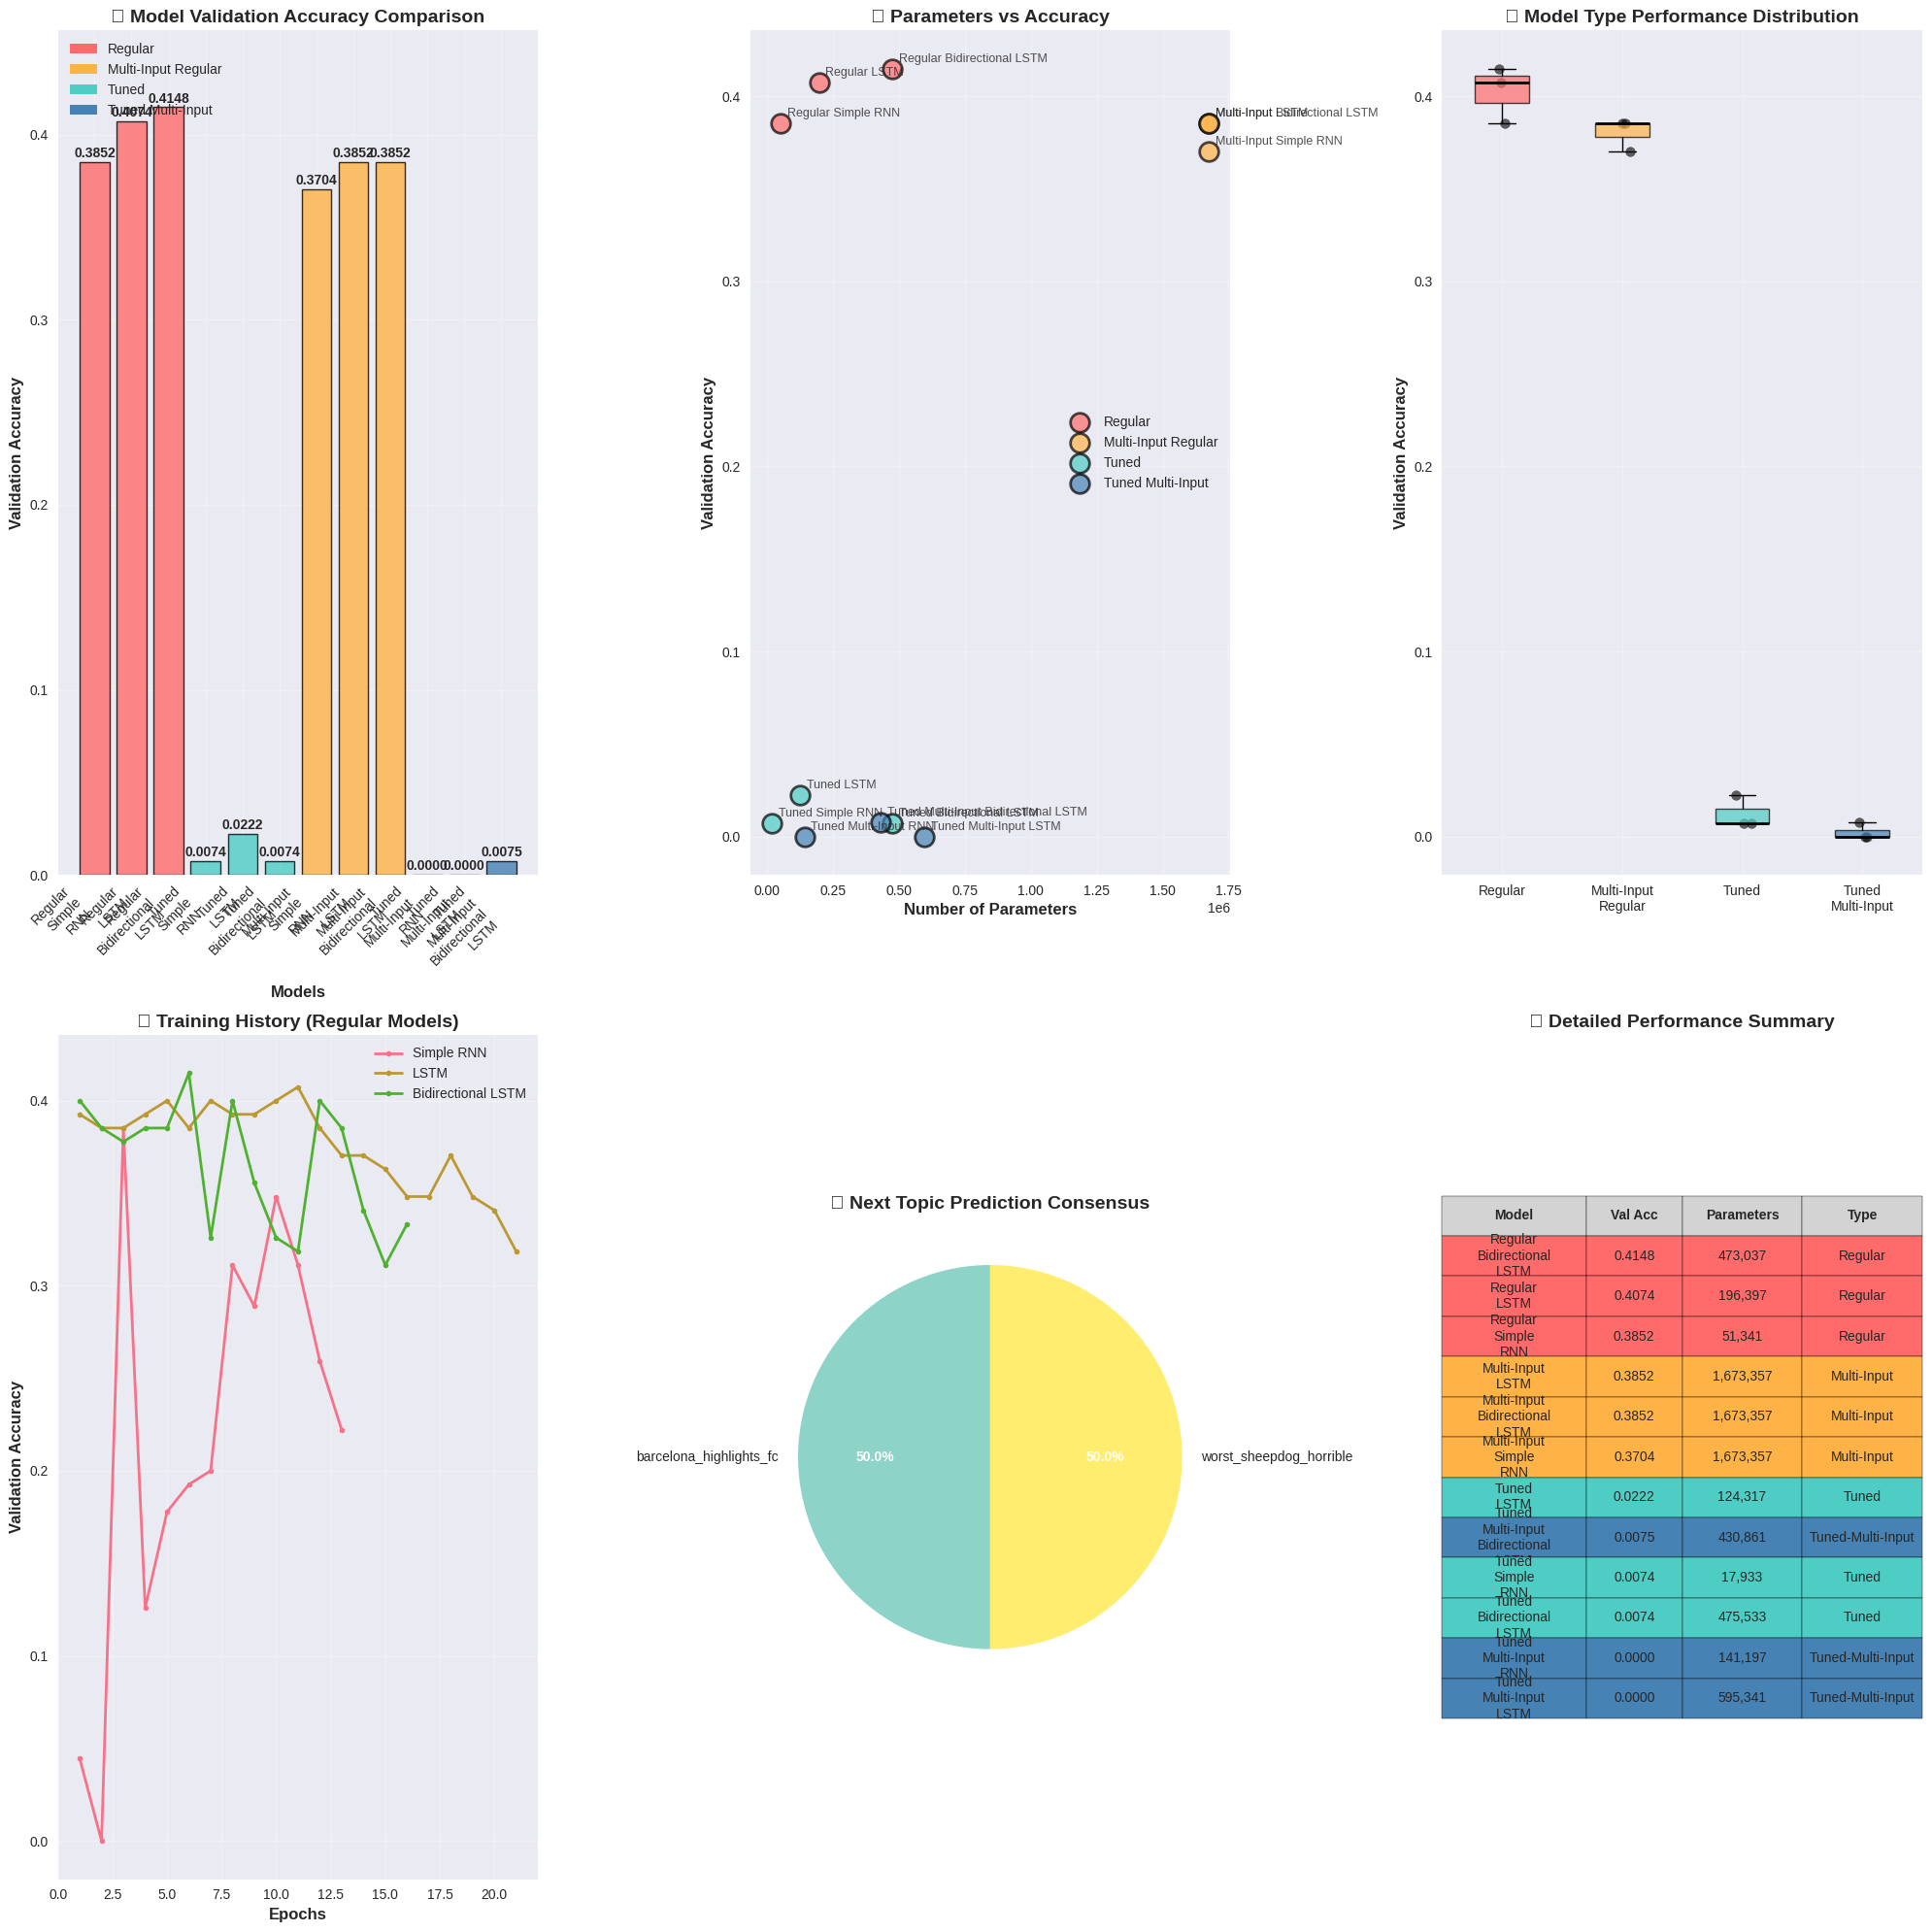

In [221]:
print("📊 CREATING COMPREHENSIVE GRAPHICAL PERFORMANCE COMPARISON")
print("="*70)

# Extract data for plotting
model_names = []
val_accuracies = []
model_types = []
param_counts = []
predictions = []

# Define colors for each model type
model_type_colors = {
    'regular': '#FF6B6B',  # Red-ish
    'multi-input': '#FFB347',  # Orange-ish
    'tuned': '#4ECDC4',  # Cyan-ish
    'tuned-multi-input': '#4682B4'  # Blue-ish
}

for model_name, model_info in all_models.items():
    model_names.append(model_name.replace(' ', '\n'))  # Line breaks for better display
    val_accuracies.append(model_info['val_acc'])
    model_types.append(model_info['type'])
    param_counts.append(model_info['model'].count_params())

    # Get prediction for this model
    model = model_info['model'] # Get the actual model object
    if model_info['type'] in ['multi-input', 'tuned-multi-input']:
        try:
            # Use multi-input prediction for multi-input/tuned-multi-input models
            last_topic_seq = multi_data['topic_sequences'][-1]
            last_view_seq = multi_data['view_sequences'][-1]
            last_temporal_seq = multi_data['temporal_features'][-1]
            last_creator_seq = multi_data['creator_sequences'][-1]

            inputs = {
                'topic_input': np.array([last_topic_seq]),
                'view_input': np.array([last_view_seq]),
                'temporal_input': np.array([last_temporal_seq]),
                'creator_input': np.array([last_creator_seq])
            }
            predicted_class = model.predict(inputs, verbose=0).argmax()
            predicted_topic = le.inverse_transform([predicted_class])[0]
        except Exception as e:
            print(f"Warning: Multi-input prediction for plotting failed for {model_name}: {e}")
            predicted_topic = "Prediction Failed"
    else:
        # Use regular single-input prediction for regular/tuned models
        last_sequence = encoded_topics[-15:]
        input_seq = np.array([last_sequence])
        predicted_class = model.predict(input_seq, verbose=0).argmax()
        predicted_topic = le.inverse_transform([predicted_class])[0]
    predictions.append(predicted_topic)

# Create a comprehensive figure with multiple subplots
fig = plt.figure(figsize=(20,20))

# 1. Validation Accuracy Bar Chart
ax1 = plt.subplot(2, 3, 1)
# colors = ['#FF6B6B' if t == 'regular' else '#4ECDC4' for t in model_types] # Old color logic
colors = [model_type_colors.get(t, '#808080') for t in model_types] # Default to gray if type not in map
bars = ax1.bar(range(len(model_names)), val_accuracies, color=colors, alpha=0.8, edgecolor='black', linewidth=1)

# Add value labels on bars
for i, (bar, acc) in enumerate(zip(bars, val_accuracies)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{acc:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

ax1.set_xlabel('Models', fontsize=12, fontweight='bold')
ax1.set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('🎯 Model Validation Accuracy Comparison', fontsize=14, fontweight='bold')
ax1.set_xticks(range(len(model_names)))
ax1.set_xticklabels(model_names, rotation=45, ha='right', fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, max(val_accuracies) * 1.1 if val_accuracies else 0.1) # handle empty val_accuracies

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor=model_type_colors['regular'], label='Regular'),
    Patch(facecolor=model_type_colors['multi-input'], label='Multi-Input Regular'),
    Patch(facecolor=model_type_colors['tuned'], label='Tuned'),
    Patch(facecolor=model_type_colors['tuned-multi-input'], label='Tuned Multi-Input')
]
ax1.legend(handles=legend_elements, loc='upper left')

# 2. Model Parameters vs Accuracy Scatter Plot
ax2 = plt.subplot(2, 3, 2)
# regular_mask = [t == 'regular' for t in model_types] # Old mask
# tuned_mask = [t == 'tuned' for t in model_types] # Old mask

# Create masks for all four model types
regular_mask = [t == 'regular' for t in model_types]
multi_input_mask = [t == 'multi-input' for t in model_types]
tuned_mask = [t == 'tuned' for t in model_types]
tuned_multi_input_mask = [t == 'tuned-multi-input' for t in model_types]


# Plot regular models
reg_params = [p for i, p in enumerate(param_counts) if regular_mask[i]]
reg_accs = [a for i, a in enumerate(val_accuracies) if regular_mask[i]]
reg_names = [n for i, n in enumerate(model_names) if regular_mask[i]]

# Plot multi-input regular models
multi_params = [p for i, p in enumerate(param_counts) if multi_input_mask[i]]
multi_accs = [a for i, a in enumerate(val_accuracies) if multi_input_mask[i]]
multi_names = [n for i, n in enumerate(model_names) if multi_input_mask[i]]

# Plot tuned models
tuned_params = [p for i, p in enumerate(param_counts) if tuned_mask[i]]
tuned_accs = [a for i, a in enumerate(val_accuracies) if tuned_mask[i]]
tuned_names = [n for i, n in enumerate(model_names) if tuned_mask[i]]

# Plot tuned multi-input models
tuned_multi_params = [p for i, p in enumerate(param_counts) if tuned_multi_input_mask[i]]
tuned_multi_accs = [a for i, a in enumerate(val_accuracies) if tuned_multi_input_mask[i]]
tuned_multi_names = [n for i, n in enumerate(model_names) if tuned_multi_input_mask[i]]


ax2.scatter(reg_params, reg_accs, c=model_type_colors['regular'], s=200, alpha=0.7,
                      edgecolors='black', linewidth=2, label='Regular')
ax2.scatter(multi_params, multi_accs, c=model_type_colors['multi-input'], s=200, alpha=0.7,
                      edgecolors='black', linewidth=2, label='Multi-Input Regular')
ax2.scatter(tuned_params, tuned_accs, c=model_type_colors['tuned'], s=200, alpha=0.7,
                      edgecolors='black', linewidth=2, label='Tuned')
ax2.scatter(tuned_multi_params, tuned_multi_accs, c=model_type_colors['tuned-multi-input'], s=200, alpha=0.7,
                      edgecolors='black', linewidth=2, label='Tuned Multi-Input')


# Add labels for each point
for i, (x, y, name) in enumerate(zip(reg_params, reg_accs, reg_names)):
    ax2.annotate(name.replace('\n', ' '), (x, y), xytext=(5, 5), textcoords='offset points',
                fontsize=9, alpha=0.8)
for i, (x, y, name) in enumerate(zip(multi_params, multi_accs, multi_names)):
    ax2.annotate(name.replace('\n', ' '), (x, y), xytext=(5, 5), textcoords='offset points',
                fontsize=9, alpha=0.8)
for i, (x, y, name) in enumerate(zip(tuned_params, tuned_accs, tuned_names)):
    ax2.annotate(name.replace('\n', ' '), (x, y), xytext=(5, 5), textcoords='offset points',
                fontsize=9, alpha=0.8)
for i, (x, y, name) in enumerate(zip(tuned_multi_params, tuned_multi_accs, tuned_multi_names)):
    ax2.annotate(name.replace('\n', ' '), (x, y), xytext=(5, 5), textcoords='offset points',
                fontsize=9, alpha=0.8)


ax2.set_xlabel('Number of Parameters', fontsize=12, fontweight='bold')
ax2.set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('🔧 Parameters vs Accuracy', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Model Type Performance Comparison
ax3 = plt.subplot(2, 3, 3)
regular_accs_bp = [a for i, a in enumerate(val_accuracies) if model_types[i] == 'regular']
multi_input_accs_bp = [a for i, a in enumerate(val_accuracies) if model_types[i] == 'multi-input']
tuned_accs_bp = [a for i, a in enumerate(val_accuracies) if model_types[i] == 'tuned']
tuned_multi_input_accs_bp = [a for i, a in enumerate(val_accuracies) if model_types[i] == 'tuned-multi-input']

box_data = [acc_list for acc_list in [regular_accs_bp, multi_input_accs_bp, tuned_accs_bp, tuned_multi_input_accs_bp] if acc_list] # Filter out empty lists
box_labels_all = ['Regular', 'Multi-Input\nRegular', 'Tuned', 'Tuned\nMulti-Input']
colors_box_all = [model_type_colors['regular'], model_type_colors['multi-input'], model_type_colors['tuned'], model_type_colors['tuned-multi-input']]

# Filter labels and colors based on non-empty data
box_labels = [box_labels_all[i] for i, acc_list in enumerate([regular_accs_bp, multi_input_accs_bp, tuned_accs_bp, tuned_multi_input_accs_bp]) if acc_list]
colors_box = [colors_box_all[i] for i, acc_list in enumerate([regular_accs_bp, multi_input_accs_bp, tuned_accs_bp, tuned_multi_input_accs_bp]) if acc_list]


if box_data: # Only plot if there's data
    bp = ax3.boxplot(box_data, labels=box_labels, patch_artist=True,
                     boxprops=dict(alpha=0.7), medianprops=dict(color='black', linewidth=2))

    for patch, color in zip(bp['boxes'], colors_box):
        patch.set_facecolor(color)

    # Add individual points
    for i, data in enumerate(box_data):
        if data: # Check if data is not empty
            y_points = data
            x_points = np.random.normal(i + 1, 0.04, size=len(y_points)) # i+1 because boxplot positions are 1-based
            ax3.scatter(x_points, y_points, alpha=0.6, s=50, color='black')
else:
    ax3.text(0.5, 0.5, 'No data for box plot', ha='center', va='center', transform=ax3.transAxes)


ax3.set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax3.set_title('📈 Model Type Performance Distribution', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Training History Comparison (if available) - FIXED VERSION
ax4 = plt.subplot(2, 3, 4)
# Create a robust mapping for training history
history_plotted = False
# Define the correct mapping between all_models keys and results keys
results_key_mapping = {
    'Regular Simple RNN': 'Simple RNN',
    'Regular LSTM': 'Regular LSTM',
    'Regular Bidirectional LSTM': 'Bidirectional LSTM'
}
for model_name_key, model_info_val in all_models.items(): # Renamed variables to avoid conflict
    if model_info_val['type'] == 'regular':
        # Try to find the correct key in results
        possible_keys = [
            results_key_mapping.get(model_name_key),  # Use mapping first
            model_name_key,  # Try exact match
            model_name_key.replace('Regular ', ''),  # Remove 'Regular ' prefix
            model_name_key.split()[-1],  # Try last word only
        ]
        # Filter out None values
        possible_keys = [key for key in possible_keys if key is not None]
        for key in possible_keys:
            if key in results and 'history' in results[key]:
                history = results[key]['history']
                if 'val_accuracy' in history.history and len(history.history['val_accuracy']) > 0:
                    epochs_range = range(1, len(history.history['val_accuracy']) + 1) # Renamed variable
                    ax4.plot(epochs_range, history.history['val_accuracy'],
                            label=model_name_key.replace('Regular ', ''),
                            linewidth=2, marker='o', markersize=4)
                    history_plotted = True
                    break # Found history for this model_name_key, move to next

# If no history was plotted, show a message
if not history_plotted:
    ax4.text(0.5, 0.5, 'No training history available\nfor regular models',
            ha='center', va='center', transform=ax4.transAxes,
            fontsize=12, style='italic')

ax4.set_xlabel('Epochs', fontsize=12, fontweight='bold')
ax4.set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax4.set_title('📊 Training History (Regular Models)', fontsize=14, fontweight='bold')
if history_plotted:
    ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Prediction Consensus Pie Chart
ax5 = plt.subplot(2, 3, 5)
prediction_counts = Counter(predictions) # Ensure 'predictions' list is populated before this
labels_pie = list(prediction_counts.keys()) # Renamed variable
sizes_pie = list(prediction_counts.values()) # Renamed variable
colors_pie = plt.cm.Set3(np.linspace(0, 1, len(labels_pie)))

wedges, texts, autotexts = ax5.pie(sizes_pie, labels=labels_pie, autopct='%1.1f%%',
                                   colors=colors_pie, startangle=90)

# Beautify the pie chart
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

ax5.set_title('🎯 Next Topic Prediction Consensus', fontsize=14, fontweight='bold')

# 6. Detailed Performance Metrics
ax6 = plt.subplot(2, 3, 6)
# Create a performance summary table
metrics_data = []
for model_name, model_info in all_models.items():
    metrics_data.append([
        model_name.replace(' ', '\n'),
        f"{model_info['val_acc']:.4f}",
        f"{model_info['model'].count_params():,}",
        model_info['type'].title() # This will be used for coloring
    ])

# Sort by validation accuracy
metrics_data.sort(key=lambda x: float(x[1]), reverse=True)

# Create table
table = ax6.table(cellText=metrics_data,
                  colLabels=['Model', 'Val Acc', 'Parameters', 'Type'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.3, 0.2, 0.25, 0.25])

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2)

# Color code the rows based on the four model types
for i in range(len(metrics_data)): # Iterate up to the number of data rows
    model_type_in_table = metrics_data[i][3].lower().replace(' ', '-') # Get type from sorted metrics_data
    color = model_type_colors.get(model_type_in_table, '#D3D3D3') # Default to light gray

    for j in range(4): # Iterate through columns
        table[(i + 1, j)].set_facecolor(color) # i+1 because table rows are 1-indexed after header


# Header styling
for j in range(4):
    table[(0, j)].set_facecolor('#D3D3D3')
    table[(0, j)].set_text_props(weight='bold')

ax6.axis('off')
ax6.set_title('📋 Detailed Performance Summary', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()


📊 INTERACTIVE MODEL COMPARISON


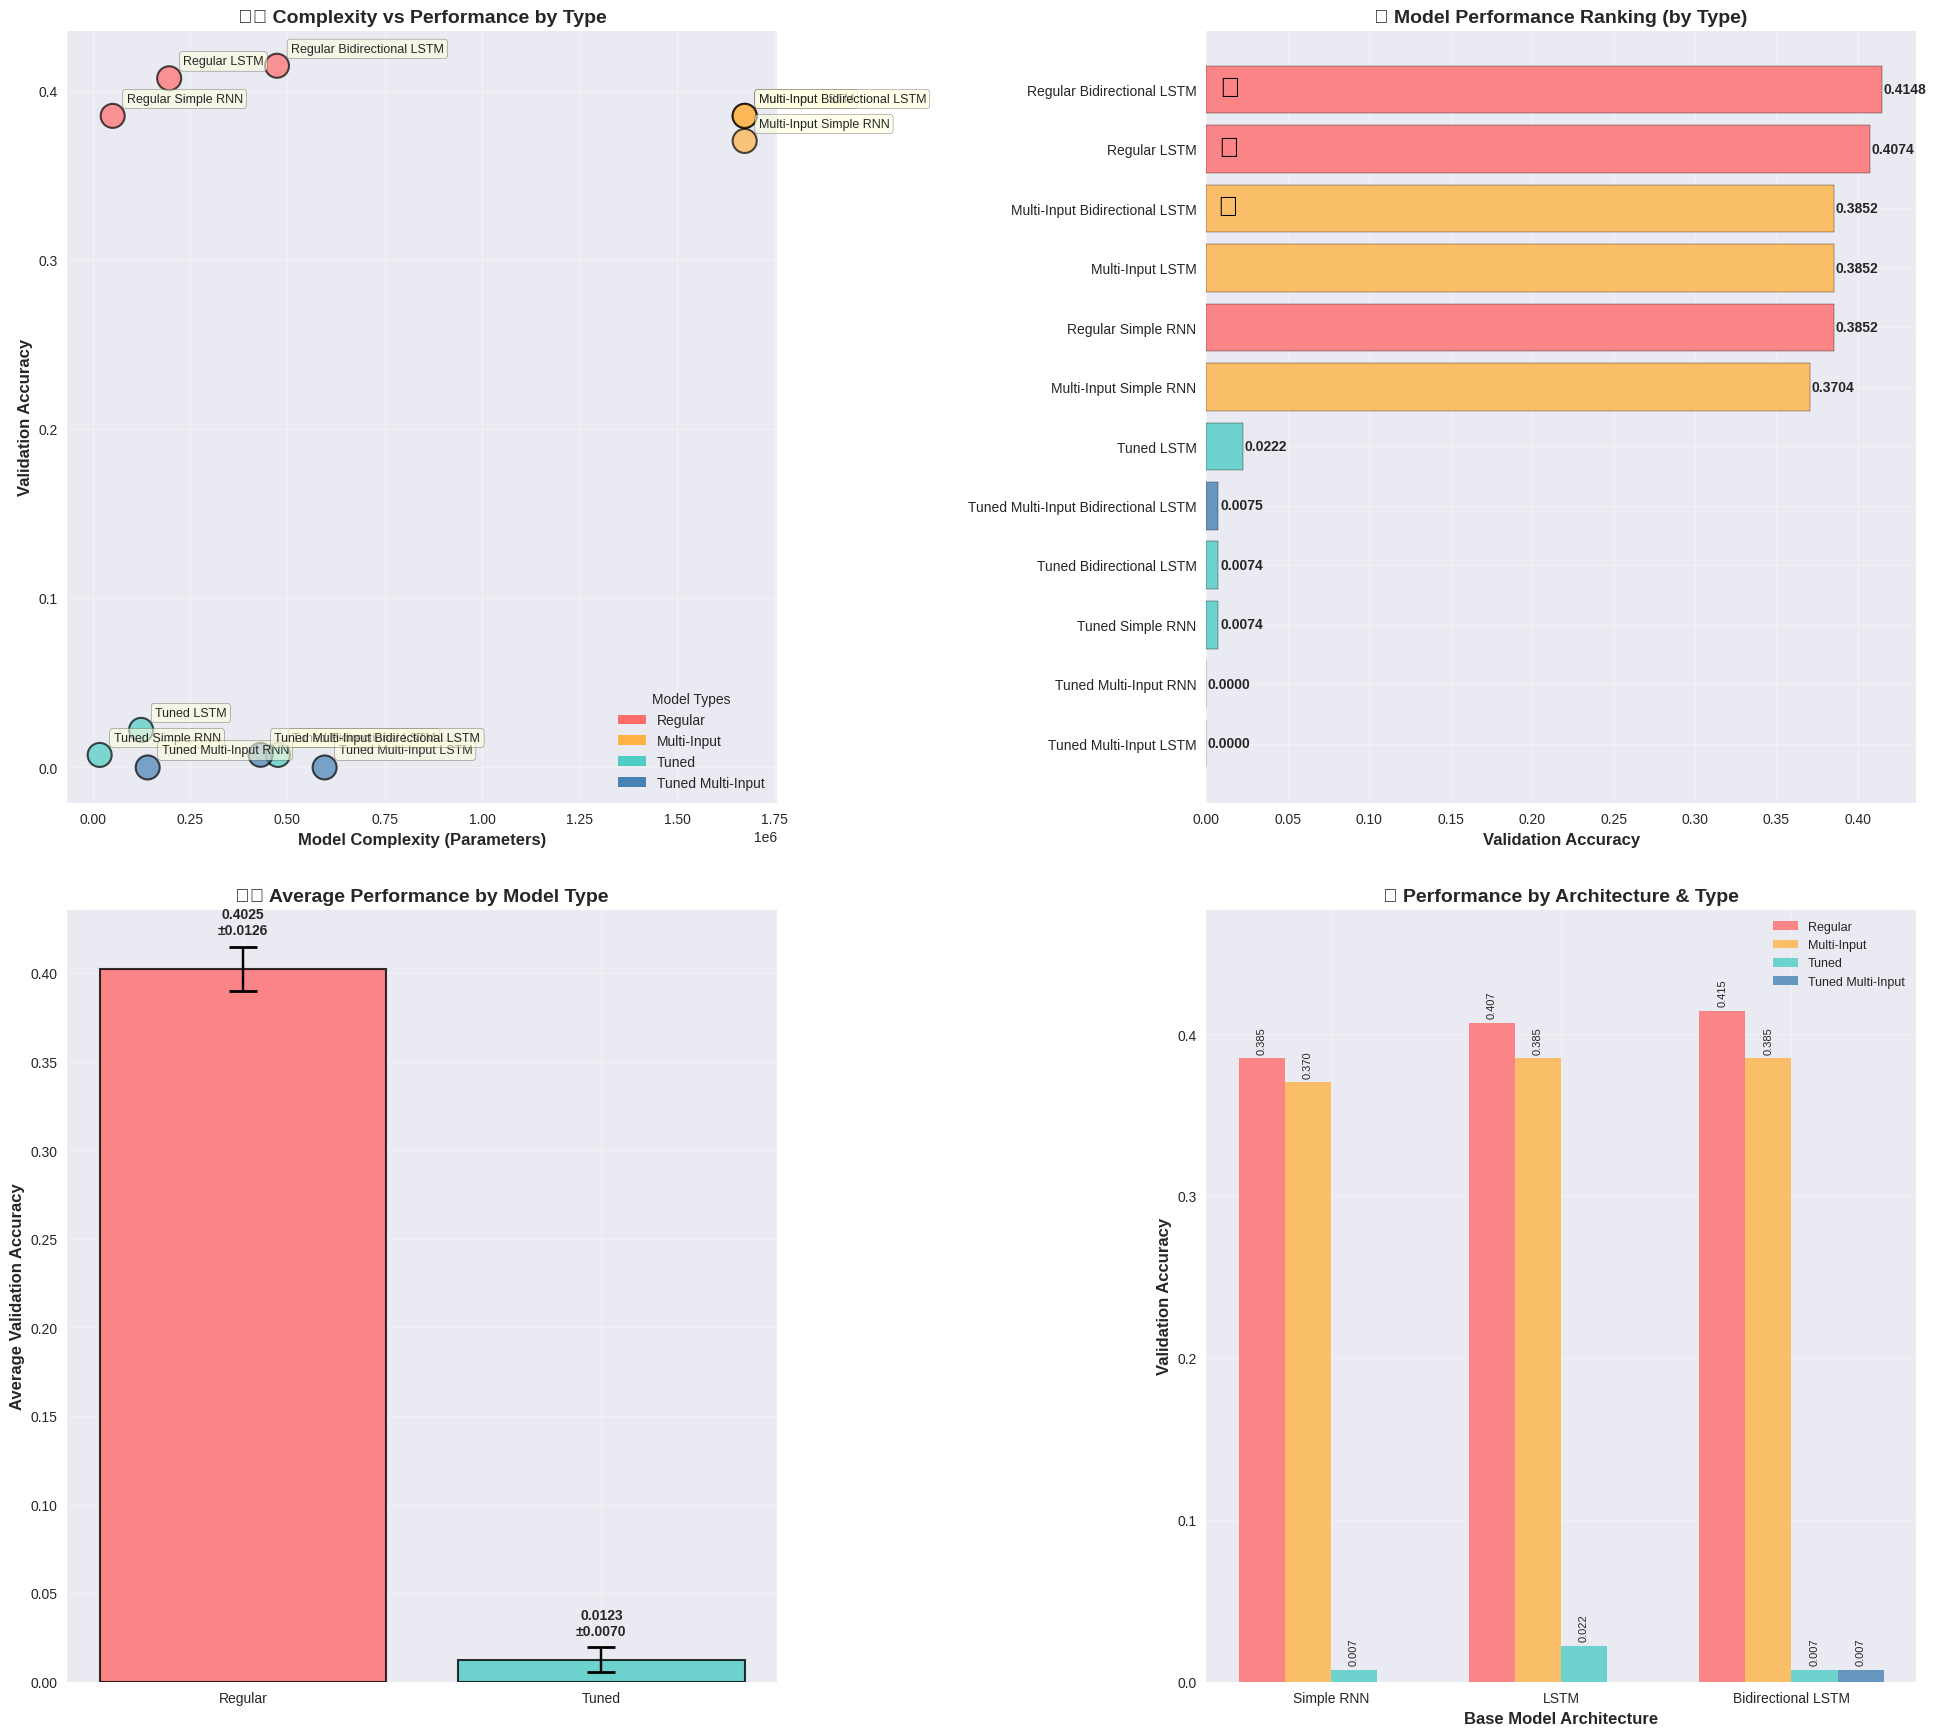

In [222]:
print("\n" + "="*70)
print("📊 INTERACTIVE MODEL COMPARISON")
print("="*70)

# Create a separate figure for model architecture comparison
fig2, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 18)) # Increased figsize slightly

# 1. Architecture Complexity vs Performance
scatter_colors = [model_type_colors.get(t, '#808080') for t in model_types]
ax1.scatter(param_counts, val_accuracies, c=scatter_colors,
            s=300, alpha=0.7, edgecolors='black', linewidth=1.5)

for i, (x_coord, y_coord, name_label) in enumerate(zip(param_counts, val_accuracies, model_names)):
    ax1.annotate(name_label.replace('\n', ' '), (x_coord, y_coord), xytext=(10, 10),
                 textcoords='offset points', fontsize=9,
                 bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', alpha=0.6))

ax1.set_xlabel('Model Complexity (Parameters)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax1.set_title('🏗️ Complexity vs Performance by Type', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

from matplotlib.patches import Patch
legend_elements_ax1 = [
    Patch(facecolor=model_type_colors['regular'], label='Regular'),
    Patch(facecolor=model_type_colors['multi-input'], label='Multi-Input'),
    Patch(facecolor=model_type_colors['tuned'], label='Tuned'),
    Patch(facecolor=model_type_colors['tuned-multi-input'], label='Tuned Multi-Input')
]
ax1.legend(handles=legend_elements_ax1, title="Model Types", loc='lower right')


# 2. Performance Ranking (Colored by Model Type)
sorted_indices = np.argsort(val_accuracies)[::-1]
rankings = [model_names[i].replace('\n', ' ') for i in sorted_indices]
ranking_accs = [val_accuracies[i] for i in sorted_indices]
ranked_model_types = [model_types[i] for i in sorted_indices]
ranking_bar_colors = [model_type_colors.get(t, '#808080') for t in ranked_model_types]

bars_ax2 = ax2.barh(range(len(rankings)), ranking_accs, color=ranking_bar_colors, alpha=0.8, edgecolor='black')

for i, (bar, acc) in enumerate(zip(bars_ax2, ranking_accs)):
    width = bar.get_width()
    ax2.text(width + 0.001, bar.get_y() + bar.get_height()/2.,
             f'{acc:.4f}', ha='left', va='center', fontsize=10, fontweight='bold')

ax2.set_yticks(range(len(rankings)))
ax2.set_yticklabels(rankings, fontsize=10)
ax2.set_xlabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax2.set_title('🏆 Model Performance Ranking (by Type)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.invert_yaxis() # Display best model at the top

# Add ranking medals
for i, y_pos in enumerate(range(len(rankings))):
    if i == 0:
        ax2.text(ranking_accs[i] * 0.05, y_pos, '🥇', ha='right', va='center', fontsize=20, color='black')
    elif i == 1:
        ax2.text(ranking_accs[i] * 0.05, y_pos, '🥈', ha='right', va='center', fontsize=20, color='black')
    elif i == 2:
        ax2.text(ranking_accs[i] * 0.05, y_pos, '🥉', ha='right', va='center', fontsize=20, color='black')

# 3. Average Performance by Model Type
type_names_ax3 = ['Regular', 'Multi-Input', 'Tuned', 'Tuned Multi-Input']
accuracies_by_type_ax3 = {
    'Regular': [val_accuracies[i] for i, t in enumerate(model_types) if t == 'regular'],
    'Multi-Input': [val_accuracies[i] for i, t in enumerate(model_types) if t == 'multi-input'],
    'Tuned': [val_accuracies[i] for i, t in enumerate(model_types) if t == 'tuned'],
    'Tuned Multi-Input': [val_accuracies[i] for i, t in enumerate(model_types) if t == 'tuned-multi-input']
}

means_ax3 = []
stds_ax3 = []
labels_ax3_active = []
colors_ax3_active = []

for type_name_key in ['regular', 'multi-input', 'tuned', 'tuned-multi-input']:
    # Correctly generate the key for the accuracies_by_type_ax3 dictionary
    dict_lookup_key = type_name_key.replace('-', ' ').title()

    # Check if the key exists and has data before accessing
    if dict_lookup_key in accuracies_by_type_ax3 and accuracies_by_type_ax3[dict_lookup_key]:
        accs_list = accuracies_by_type_ax3[dict_lookup_key]
        means_ax3.append(np.mean(accs_list))
        stds_ax3.append(np.std(accs_list))
        labels_ax3_active.append(type_name_key.replace('-', ' ').title().replace('Multi Input', 'Multi-Input\n'))
        colors_ax3_active.append(model_type_colors[type_name_key])
if labels_ax3_active:
    ax3.bar(labels_ax3_active, means_ax3, color=colors_ax3_active, alpha=0.8, edgecolor='black', linewidth=1.5)
    ax3.errorbar(labels_ax3_active, means_ax3, yerr=stds_ax3,
                 fmt='none', color='black', capsize=10, capthick=2)

    for i, (avg, std_dev) in enumerate(zip(means_ax3, stds_ax3)):
        ax3.text(i, avg + std_dev + 0.005, f'{avg:.4f}\n±{std_dev:.4f}',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')
else:
    ax3.text(0.5, 0.5, "No data for this plot.", transform=ax3.transAxes, ha="center", va="center")


ax3.set_ylabel('Average Validation Accuracy', fontsize=12, fontweight='bold')
ax3.set_title('⚖️ Average Performance by Model Type', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', labelsize=10)


# 4. Performance by Architecture and Type
model_bases = ['Simple RNN', 'LSTM', 'Bidirectional LSTM']
data_for_ax4 = {
    'Regular': [],
    'Multi-Input': [],
    'Tuned': [],
    'Tuned Multi-Input': []
}
key_map_ax4 = {
    'Regular': 'regular',
    'Multi-Input': 'multi-input',
    'Tuned': 'tuned',
    'Tuned Multi-Input': 'tuned-multi-input'
}


for base in model_bases:
    data_for_ax4['Regular'].append(all_models.get(f'Regular {base}', {}).get('val_acc', 0))
    data_for_ax4['Multi-Input'].append(all_models.get(f'Multi-Input {base}', {}).get('val_acc', 0))
    data_for_ax4['Tuned'].append(all_models.get(f'Tuned {base}', {}).get('val_acc', 0))
    data_for_ax4['Tuned Multi-Input'].append(all_models.get(f'Tuned Multi-Input {base}', {}).get('val_acc', 0))

x_ax4 = np.arange(len(model_bases))
width_ax4 = 0.20  # Adjusted width for 4 bars

# Plotting bars for each type
rects1 = ax4.bar(x_ax4 - 1.5 * width_ax4, data_for_ax4['Regular'], width_ax4, label='Regular', color=model_type_colors['regular'], alpha=0.8)
rects2 = ax4.bar(x_ax4 - 0.5 * width_ax4, data_for_ax4['Multi-Input'], width_ax4, label='Multi-Input', color=model_type_colors['multi-input'], alpha=0.8)
rects3 = ax4.bar(x_ax4 + 0.5 * width_ax4, data_for_ax4['Tuned'], width_ax4, label='Tuned', color=model_type_colors['tuned'], alpha=0.8)
rects4 = ax4.bar(x_ax4 + 1.5 * width_ax4, data_for_ax4['Tuned Multi-Input'], width_ax4, label='Tuned Multi-Input', color=model_type_colors['tuned-multi-input'], alpha=0.8)

# Add value labels on bars for ax4
def autolabel(rects, ax):
    for rect in rects:
        height = rect.get_height()
        if height > 0: # Only label non-zero bars
            ax.annotate(f'{height:.3f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=8, rotation=90)
autolabel(rects1, ax4)
autolabel(rects2, ax4)
autolabel(rects3, ax4)
autolabel(rects4, ax4)

ax4.set_xlabel('Base Model Architecture', fontsize=12, fontweight='bold')
ax4.set_ylabel('Validation Accuracy', fontsize=12, fontweight='bold')
ax4.set_title('📈 Performance by Architecture & Type', fontsize=14, fontweight='bold')
ax4.set_xticks(x_ax4)
ax4.set_xticklabels(model_bases, fontsize=10)
ax4.legend(fontsize=9)
ax4.grid(True, alpha=0.3)
ax4.set_ylim(0, max(max(data_for_ax4['Regular']), max(data_for_ax4['Multi-Input']), max(data_for_ax4['Tuned']), max(data_for_ax4['Tuned Multi-Input'])) * 1.15)


plt.tight_layout(pad=3.0)
plt.show()

In [223]:
# Performance Statistics Summary
print(f"\n🎯 PERFORMANCE STATISTICS SUMMARY:")
print("-" * 50)
print(f"🏆 Best Model: {sorted_models[0][0]} ({sorted_models[0][1]['val_acc']:.4f})")
print(f"📊 Average Accuracy: {np.mean(val_accuracies):.4f}")
print(f"📈 Accuracy Range: {min(val_accuracies):.4f} - {max(val_accuracies):.4f}")

# Create the missing variables from your existing data
model_bases = ['Simple RNN', 'LSTM', 'Bidirectional LSTM']
regular_scores = []
tuned_scores = []

# Extract scores for regular and tuned models
for base in model_bases:
    regular_key = f'Regular {base}'
    tuned_key = f'Tuned {base}'

    # Get regular model score
    if regular_key in all_models:
        regular_scores.append(all_models[regular_key]['val_acc'])
    else:
        regular_scores.append(0)  # Default if not found

    # Get tuned model score
    if tuned_key in all_models:
        tuned_scores.append(all_models[tuned_key]['val_acc'])
    else:
        tuned_scores.append(0)  # Default if not found

# Only calculate improvement if we have valid scores
if len(regular_scores) > 0 and len(tuned_scores) > 0 and any(regular_scores) and any(tuned_scores):
    # Filter out zero scores for improvement calculation
    valid_improvements = []
    for i in range(len(regular_scores)):
        if regular_scores[i] > 0 and tuned_scores[i] > 0:
            improvement = (tuned_scores[i] - regular_scores[i]) / regular_scores[i] * 100
            valid_improvements.append(improvement)

    if valid_improvements:
        avg_improvement = np.mean(valid_improvements)
        print(f"🔧 Average Improvement from Tuning: {avg_improvement:.1f}%")

        # Find most improved architecture
        improvements = [(tuned_scores[i] - regular_scores[i]) / regular_scores[i] * 100
                       for i in range(len(regular_scores)) if regular_scores[i] > 0]
        if improvements:
            best_improvement_idx = np.argmax(improvements)
            valid_bases = [model_bases[i] for i in range(len(regular_scores)) if regular_scores[i] > 0]
            if valid_bases:
                print(f"💪 Most Improved Architecture: {valid_bases[best_improvement_idx]}")
else:
    print("🔧 Tuning improvement data not available")
    print("💪 Most improved architecture data not available")


🎯 PERFORMANCE STATISTICS SUMMARY:
--------------------------------------------------
🏆 Best Model: Regular Bidirectional LSTM (0.4148)
📊 Average Accuracy: 0.1994
📈 Accuracy Range: 0.0000 - 0.4148
🔧 Average Improvement from Tuning: -96.9%
💪 Most Improved Architecture: LSTM


### Next 10 topics

In [224]:
def predict_next_n_topics(model, le, encoded_topics, n_predictions=10, sequence_length=15):
    # ? start with the last sequence from training data
    current_sequence = list(encoded_topics[-sequence_length:])
    predicted_topics = []

    for i in range(n_predictions):
        # ? reshape for model input
        input_seq = np.array([current_sequence])

        # ? predict
        predicted_probs = model.predict(input_seq, verbose=0)
        predicted_class = predicted_probs.argmax()

        # ? store prediction
        predicted_topics.append(predicted_class)

        # ? update sequence: remove first element, add prediction
        current_sequence = current_sequence[1:] + [predicted_class]

    # ? convert encoded predictions back to topic names
    predicted_topic_names = le.inverse_transform(predicted_topics)
    return predicted_topic_names, predicted_topics

In [225]:
def predict_next_n_topics_multi(model, le, multi_data, n_predictions=10):
    """Predict using multi-input model"""
    # Start with last sequence
    topic_seq = list(multi_data['topic_sequences'][-1])
    view_seq = list(multi_data['view_sequences'][-1])
    temporal_seq = list(multi_data['temporal_features'][-1])
    creator_seq = list(multi_data['creator_sequences'][-1])  # Fixed: was 'channel_seq'

    predicted_topics = []

    for i in range(n_predictions):
        # Prepare inputs with correct key names
        inputs = {
            'topic_input': np.array([topic_seq]),
            'view_input': np.array([view_seq]),
            'temporal_input': np.array([temporal_seq]),
            'creator_input': np.array([creator_seq])  # Fixed: was 'channel_input'
        }

        # Predict
        predicted_probs = model.predict(inputs, verbose=0)
        predicted_class = predicted_probs.argmax()
        predicted_topics.append(predicted_class)

        # Update sequences (simplified - you might want more sophisticated updating)
        topic_seq = topic_seq[1:] + [predicted_class]
        # For views and temporal, you'd need more sophisticated logic
        view_seq = view_seq[1:] + [view_seq[-1]]  # Repeat last value
        creator_seq = creator_seq[1:] + [creator_seq[-1]]  # Fixed: was 'channel_seq'

    return le.inverse_transform(predicted_topics), predicted_topics

In [226]:
print("\n" + "="*100)
print("NEXT 10 TOPIC PREDICTIONS - ALL MODELS (INCLUDING MULTI-INPUT)")
print("="*100)

# Generate predictions for all models
all_model_predictions = {}

for model_name, model_info in all_models.items():
    model = model_info['model']

    # Check if this is a multi-input model
    if model_info['type'] in ['multi-input', 'tuned-multi-input']:
        try:
            # Use multi-input prediction function
            predicted_names, predicted_encoded = predict_next_n_topics_multi(
                model, le, multi_data, n_predictions=10
            )
            print(f"✅ Using multi-input prediction for {model_name}")
        except Exception as e:
            print(f"⚠️ Multi-input prediction failed for {model_name}, falling back to regular: {e}")
            # Fallback to regular prediction if multi-input fails
            predicted_names, predicted_encoded = predict_next_n_topics(
                model, le, encoded_topics, n_predictions=10, sequence_length=15
            )
    else:
        # Use regular single-input prediction function
        predicted_names, predicted_encoded = predict_next_n_topics(
            model, le, encoded_topics, n_predictions=10, sequence_length=15
        )

    all_model_predictions[model_name] = {
        'names': predicted_names,
        'encoded': predicted_encoded,
        'val_acc': model_info['val_acc']
    }

# Display predictions for each model
for model_name, predictions in all_model_predictions.items():
    model_type = all_models[model_name]['type']
    val_acc = predictions['val_acc']

    print(f"\n{'-'*60}")
    print(f"🤖 {model_name.upper()} ({model_type.title()}) - Val Acc: {val_acc:.4f}")
    print(f"{'-'*60}")

    for i, (name, encoded) in enumerate(zip(predictions['names'], predictions['encoded']), 1):
        print(f"{i:2d}. {name} (encoded: {encoded})")

    print(f"\n📝 Sequence: {' → '.join(predictions['names'])}")

# Enhanced comparison table with better formatting
print(f"\n" + "="*150)
print("📊 COMPREHENSIVE SIDE-BY-SIDE COMPARISON TABLE")
print("="*150)

# Create headers with model types
model_names_list = list(all_model_predictions.keys())
header = f"{'Pos':<4}"
type_header = f"{'Type':<4}"

for name in model_names_list:
    model_type = all_models[name]['type']
    header += f"{name:<25}"
    type_header += f"{model_type:<25}"

print(header)
print(type_header)
print("-" * 150)

# Create comparison rows
for i in range(10):
    row = f"{i+1:<4}"
    for model_name in model_names_list:
        prediction = all_model_predictions[model_name]['names'][i]
        # Truncate long topic names for display
        display_pred = prediction[:22] + "..." if len(prediction) > 25 else prediction
        row += f"{display_pred:<25}"
    print(row)

# Enhanced accuracy ranking with model types
print(f"\n🏅 COMPREHENSIVE MODEL RANKING BY VALIDATION ACCURACY:")
print("-" * 70)
sorted_by_acc = sorted(all_model_predictions.items(), key=lambda x: x[1]['val_acc'], reverse=True)

for rank, (model_name, pred_info) in enumerate(sorted_by_acc, 1):
    model_type = all_models[model_name]['type']
    emoji = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else "🏅"

    # Add special indicators for all model types
    type_indicator = ""
    if model_type == 'multi-input':
        type_indicator = " 🔥"
    elif model_type == 'tuned-multi-input':
        type_indicator = " 🚀"
    elif model_type == 'tuned':
        type_indicator = " ⚡"

    print(f"{emoji} {rank:2d}. {model_name:<30} ({model_type:<12}): {pred_info['val_acc']:.4f}{type_indicator}")

# Enhanced consensus analysis
print(f"\n🔍 ENHANCED PREDICTION CONSENSUS ANALYSIS:")
print("-" * 50)

# Count how often each topic appears in position 1
first_predictions = [pred_info['names'][0] for pred_info in all_model_predictions.values()]
consensus_count = Counter(first_predictions)

print("Next topic consensus (Position 1):")
for topic, count in consensus_count.most_common():
    percentage = (count / len(all_model_predictions)) * 100
    bar = "█" * int(percentage / 5)  # Visual bar
    print(f"  {topic:<30}: {count:2d}/{len(all_model_predictions)} models ({percentage:5.1f}%) {bar}")

# Analyze consensus across all positions
print(f"\nOverall topic frequency across all 10 positions:")
all_predictions_flat = []
for pred_info in all_model_predictions.values():
    all_predictions_flat.extend(pred_info['names'])

overall_consensus = Counter(all_predictions_flat)
print("Top 5 most predicted topics overall:")
for i, (topic, count) in enumerate(overall_consensus.most_common(5), 1):
    percentage = (count / len(all_predictions_flat)) * 100
    print(f"  {i}. {topic:<30}: {count:3d} occurrences ({percentage:5.1f}%)")

# Enhanced summary statistics by model type
print(f"\n📋 DETAILED SUMMARY BY MODEL TYPE:")
print("-" * 50)

model_types_summary = {}
for model_name, model_info in all_models.items():
    model_type = model_info['type']
    if model_type not in model_types_summary:
        model_types_summary[model_type] = []
    model_types_summary[model_type].append(model_info['val_acc'])

for model_type, accuracies in model_types_summary.items():
    count = len(accuracies)
    avg_acc = np.mean(accuracies)
    max_acc = max(accuracies)
    min_acc = min(accuracies)

    type_emoji = {
        'regular': '🔧',
        'tuned': '⚡',
        'multi-input': '🔥',
        'tuned-multi-input': '🚀'
    }.get(model_type, '📊')

    print(f"{type_emoji} {model_type.title()} Models ({count}):")
    print(f"   Average Accuracy: {avg_acc:.4f}")
    print(f"   Best Accuracy:    {max_acc:.4f}")
    print(f"   Range:           {min_acc:.4f} - {max_acc:.4f}")
    print()

print(f"🎯 OVERALL STATISTICS:")
print(f"   Total Models Compared: {len(all_models)}")
print(f"   Best Overall Accuracy: {max(info['val_acc'] for info in all_models.values()):.4f}")
print(f"   Average Accuracy: {sum(info['val_acc'] for info in all_models.values()) / len(all_models):.4f}")

# Enhanced performance improvement analysis
regular_best = max([info['val_acc'] for name, info in all_models.items() if info['type'] == 'regular'])
tuned_best = max([info['val_acc'] for name, info in all_models.items() if info['type'] == 'tuned'], default=0)
multi_input_best = max([info['val_acc'] for name, info in all_models.items() if info['type'] == 'multi-input'], default=0)
tuned_multi_input_best = max([info['val_acc'] for name, info in all_models.items() if info['type'] == 'tuned-multi-input'], default=0)

print(f"\n📈 IMPROVEMENT ANALYSIS (vs Regular Models baseline: {regular_best:.4f}):")

if tuned_best > 0:
    tuned_improvement = ((tuned_best - regular_best) / regular_best) * 100
    print(f"   ⚡ Tuned Models Best Improvement: +{tuned_improvement:.1f}% (Best: {tuned_best:.4f})")

if multi_input_best > 0:
    multi_input_improvement = ((multi_input_best - regular_best) / regular_best) * 100
    print(f"   🔥 Multi-Input Models Best Improvement: +{multi_input_improvement:.1f}% (Best: {multi_input_best:.4f})")

if tuned_multi_input_best > 0:
    tuned_multi_input_improvement = ((tuned_multi_input_best - regular_best) / regular_best) * 100
    print(f"   🚀 Tuned Multi-Input Models Best Improvement: +{tuned_multi_input_improvement:.1f}% (Best: {tuned_multi_input_best:.4f})")

# Find the overall best performing model type
best_scores = {
    'Regular': regular_best,
    'Tuned': tuned_best if tuned_best > 0 else 0,
    'Multi-Input': multi_input_best if multi_input_best > 0 else 0,
    'Tuned-Multi-Input': tuned_multi_input_best if tuned_multi_input_best > 0 else 0
}

best_type = max(best_scores, key=best_scores.get)
best_score = best_scores[best_type]

print(f"\n🏆 BEST PERFORMING MODEL TYPE: {best_type} ({best_score:.4f})")

# Calculate average improvements by type
type_averages = {}
for model_type in ['regular', 'tuned', 'multi-input', 'tuned-multi-input']:
    type_scores = [info['val_acc'] for name, info in all_models.items() if info['type'] == model_type]
    if type_scores:
        type_averages[model_type] = np.mean(type_scores)

if type_averages:
    print(f"\n📊 AVERAGE PERFORMANCE BY TYPE:")
    for model_type, avg_score in sorted(type_averages.items(), key=lambda x: x[1], reverse=True):
        if model_type != 'regular':
            improvement = ((avg_score - type_averages['regular']) / type_averages['regular']) * 100
            emoji = {'tuned': '⚡', 'multi-input': '🔥', 'tuned-multi-input': '🚀'}.get(model_type, '📊')
            print(f"   {emoji} {model_type.title()}: {avg_score:.4f} (+{improvement:+.1f}% avg improvement)")
        else:
            print(f"   🔧 {model_type.title()}: {avg_score:.4f} (baseline)")


NEXT 10 TOPIC PREDICTIONS - ALL MODELS (INCLUDING MULTI-INPUT)
✅ Using multi-input prediction for Multi-Input Simple RNN
✅ Using multi-input prediction for Multi-Input LSTM
✅ Using multi-input prediction for Multi-Input Bidirectional LSTM
✅ Using multi-input prediction for Tuned Multi-Input RNN
✅ Using multi-input prediction for Tuned Multi-Input LSTM
✅ Using multi-input prediction for Tuned Multi-Input Bidirectional LSTM

------------------------------------------------------------
🤖 REGULAR SIMPLE RNN (Regular) - Val Acc: 0.3852
------------------------------------------------------------
 1. barcelona_highlights_fc (encoded: 0)
 2. barcelona_highlights_fc (encoded: 0)
 3. barcelona_highlights_fc (encoded: 0)
 4. barcelona_highlights_fc (encoded: 0)
 5. barcelona_highlights_fc (encoded: 0)
 6. barcelona_highlights_fc (encoded: 0)
 7. barcelona_highlights_fc (encoded: 0)
 8. barcelona_highlights_fc (encoded: 0)
 9. barcelona_highlights_fc (encoded: 0)
10. barcelona_highlights_fc (enc